# EDA - Walmart - preprocessing
> # index
### 1. 데이터 불러오기 및 함수 호출
### 2. 사전 데이터정제 및 garbage값 제거 (근거 간략요약)
    0) 3년기간동안 units가 모두 = 0 인 값 제거(존재하지않는 아이템값은 0이라고 가정한다)
    2) 데이터열 자료형 최적화
    3) 날씨코드구분
    4) 전체데이터 조합
    5) 날짜분할(년,월,일), 온도차, 컬럼생성
### 3. 데이터 column간 유사성/상관수준 비교
### 4. 데이터 병합 및 분석전 시도
### 5. 상세분석
### 6. 아웃라이어/레버리지 판단
### 7. 회귀분석 시도
    
### 부록 : 데이터 정제 근거자료

---
# 1. 데이터 불러오기 및 함수호출=========================



In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [4]:
# ★ 함수선언 ------------------------------------------------------
#-------날씨요소기준// 날짜-스테이션 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날씨요소기준// 날짜별 스테이션(숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------날씨요소기준// 스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg

#=============================================================================

#------★★완전체 형변환 함수(M,T,__T,None)==> 있는열도 변환 가능
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df



In [5]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)
weather_p = type_change_numeric(weather,["station_nbr","codesum","date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])
weather_p["tdelta"] = weather_p["tmax"]-weather_p["tmin"]

weather_p["RA"] = (weather_p['codesum'].str.contains("RA")== 1).astype(int)
weather_p["BR"] = (weather_p['codesum'].str.contains("BR")== 1).astype(int)
weather_p["HZ"] = (weather_p['codesum'].str.contains("HZ")== 1).astype(int)
weather_p["TS"] = (weather_p['codesum'].str.contains("TS")== 1).astype(int)
weather_p["FG"] = (weather_p['codesum'].str.contains("FG")== 1).astype(int)
weather_p["SN"] = (weather_p['codesum'].str.contains("SN")== 1).astype(int)

In [6]:
# weather_p[["RA","BR","HZ","TS","FG","SN"]]

In [7]:
weather_p.dtypes

station_nbr             int64
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
tdelta                float64
RA                      int32
BR                      int32
HZ                      int32
TS                      int32
FG                      int32
SN                      int32
dtype: object

---
# 2. 사전 데이터정제 및 Garbage값 제거===================

In [8]:
# 0) units = 0 인값 제거한 데이터프레임 만들기 (주의! units=0인값이 전혀 나오지 않게됩니다.)
 #  └-- 장점으로는 계산이 빠르다 + 없는값을 제외하고 볼 수 있어서 그래프 그릴때 편하다. 
store_df = store_data[store_data["units"]!=0]

In [9]:
#   └--units = 0인값을 다시 복구하고 싶을시 사용하시오 (주의! 뭘하든 오래걸리게됩니다.)
store_df = store_data 

In [10]:
# 1) 데이터 형변환(날짜 및 숫자)
import time

store_df["date"] = pd.to_datetime(store_df["date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])

In [11]:
# 4) 전체데이터 조합 merge
#- 1. store_data에 스테이션 넘버 부여
result_df = store_df.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들
#- 2. 종합세팅
all_set = new_df.merge(weather_p, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )

In [12]:
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
temp_df = type_change_numeric(all_set,["date","store_nbr","item_nbr","units","station_nbr","codesum"])

In [13]:
master = all_set.sort_values(["date","store_nbr","item_nbr"])

In [14]:
#날짜 분해 및 데이터정제

master['year'] = master['date'].dt.year
master['month'] = master['date'].dt.month
master['day'] = master['date'].dt.day
master['DOW']= master['date'].dt.dayofweek
master['SS']= (master['month']//3)%4 
#ss는 SeaSon의 약자로 0겨울 1봄 2여름 3가을 이다.

In [15]:
master[master["month"]==12]

date  store_nbr  station_nbr  item_nbr  units  tmax  tmin  tavg  \
37185  2012-12-01          1            1         1      0  29.0  25.0  27.0   
37186  2012-12-01          1            1         2      0  29.0  25.0  27.0   
37187  2012-12-01          1            1         3      0  29.0  25.0  27.0   
37188  2012-12-01          1            1         4      0  29.0  25.0  27.0   
37189  2012-12-01          1            1         5      0  29.0  25.0  27.0   
37190  2012-12-01          1            1         6      0  29.0  25.0  27.0   
37191  2012-12-01          1            1         7      0  29.0  25.0  27.0   
37192  2012-12-01          1            1         8      0  29.0  25.0  27.0   
37193  2012-12-01          1            1         9     53  29.0  25.0  27.0   
37194  2012-12-01          1            1        10      0  29.0  25.0  27.0   
37195  2012-12-01          1            1        11      0  29.0  25.0  27.0   
37196  2012-12-01          1            1        12      0  29.0  25.0  27.0   
37197  2012-12-01          1            1        13      0  29.0  25.0  27.0   
37198  2012-12-01          1            1        14      0  29.0  25.0  27.0   
37199  2012-12-01          1            1        15      0  29.0  25.0  27.0   
37200  2012-12-01          1            1        16      0  29.0  25.0  27.0   
37201  2012-12-01          1            1        17      0  29.0  25.0  27.0   
37202  2012-12-01          1            1        18      0  29.0  25.0  27.0   
37203  2012-12-01          1            1        19      0  29.0  25.0  27.0   
37204  2012-12-01          1            1        20      0  29.0  25.0  27.0   
37205  2012-12-01          1            1        21      0  29.0  25.0  27.0   
37206  2012-12-01          1            1        22      0  29.0  25.0  27.0   
37207  2012-12-01          1            1        23      0  29.0  25.0  27.0   
37208  2012-12-01          1            1        24      0  29.0  25.0  27.0   
37209  2012-12-01          1            1        25      0  29.0  25.0  27.0   
37210  2012-12-01          1            1        26      0  29.0  25.0  27.0   
37211  2012-12-01          1            1        27      0  29.0  25.0  27.0   
37212  2012-12-01          1            1        28      8  29.0  25.0  27.0   
37213  2012-12-01          1            1        29      0  29.0  25.0  27.0   
37214  2012-12-01          1            1        30      0  29.0  25.0  27.0   
...           ...        ...          ...       ...    ...   ...   ...   ...   
386361 2013-12-31         42           14        82      0  56.0  21.0  39.0   
386362 2013-12-31         42           14        83      0  56.0  21.0  39.0   
386363 2013-12-31         42           14        84      0  56.0  21.0  39.0   
386364 2013-12-31         42           14        85      0  56.0  21.0  39.0   
386365 2013-12-31         42           14        86      0  56.0  21.0  39.0   
386366 2013-12-31         42           14        87      0  56.0  21.0  39.0   
386367 2013-12-31         42           14        88      0  56.0  21.0  39.0   
386368 2013-12-31         42           14        89      0  56.0  21.0  39.0   
386369 2013-12-31         42           14        90      0  56.0  21.0  39.0   
386370 2013-12-31         42           14        91      0  56.0  21.0  39.0   
386371 2013-12-31         42           14        92      0  56.0  21.0  39.0   
386372 2013-12-31         42           14        93      0  56.0  21.0  39.0   
386373 2013-12-31         42           14        94      0  56.0  21.0  39.0   
386374 2013-12-31         42           14        95      0  56.0  21.0  39.0   
386375 2013-12-31         42           14        96      0  56.0  21.0  39.0   
386376 2013-12-31         42           14        97      0  56.0  21.0  39.0   
386377 2013-12-31         42           14        98      0  56.0  21.0  39.0   
386378 2013-12-31         42           14        99      0  56.0  21.0  39.0   
386379 2013-1

---
# 3. 데이터 column간 유사성, 상관성 분석

In [16]:
#----------이제 특정 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")
station_speed_eachavg = station_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

#5. 이상기후온도
station_depart = weather_pivot("depart")
station_depart_avg = weather_mean("depart")

#6. 적셜량
station_snow = weather_pivot("snowfall")
station_snow_avg = weather_mean("snowfall")
station_snow_eachavg = station_mean("snowfall") #개별 스테이션별 평균 적설량

#7. 강우량
station_rain = weather_pivot("preciptotal")
station_rain_avg = weather_mean("preciptotal")
station_rain_eachavg = station_mean("preciptotal") #개별 스테이션별 평균 적설량

#8. 바람방향
station_dir = weather_pivot("resultdir")
station_dir_avg = weather_mean("resultdir")
station_dir_eachavg = station_mean("resultdir")
                           

In [17]:
# 스토어별 아이템 총 판매량
store_item = new_df.pivot_table("units","store_nbr","item_nbr", aggfunc=np.sum)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
store_item

item_nbr   1     2    3    4      5      6    7      8       9    10  ...   \
store_nbr                                                             ...    
1            0     0    0    0      0      0    0      0   27396    0 ...    
2            0     0    0    0  55104      0    0      0       0    0 ...    
3            0  1083    0    0  56663      0    0      0       0    0 ...    
4            0     0    0    0      0      0    0      0  117123    0 ...    
5            0     0    0    0      0      0    0      0       0    0 ...    
6            0     0    0    0      0      0    0      0   50431    0 ...    
7            0     0    0    0  62230      0  721      0       0    0 ...    
8            0     0    0    0  32647      0    0      0       0    0 ...    
9            0     0    0    0  45024      0    0      0       0  745 ...    
10           0     0    0    0  61866      0    0      0       0    0 ...    
11           0     0    0    0      0      0    0      0   34103    0 ...    
12           0     0    0    0      0      0    0      0       0    0 ...    
13           0     0    0    0  67241      0    0      0       0    0 ...    
14           0     0    0    0      0      0    0      0   12164    0 ...    
15           0     0    0    0  64522      0    0      0       0    0 ...    
16           0     0    0    0      0      0    0      0       0    0 ...    
17           0     0    0    0      0      0    0      0  135367    0 ...    
18           0     0    0    0  16565      0    0      0       0    0 ...    
19           0     0    0    0      0      0    0      0       0    0 ...    
20           0     0    0    0  71034      0    0      0       0    0 ...    
21           0     0    0    0  41641      0    0      0       0    0 ...    
22           0     0    0    0      0      0    0      0   42880    0 ...    
23           0     0    0    0  28810      0    0      0       0    0 ...    
24           0     0    0    0      0  41398    0      0       0    0 ...    
25           0     0    0    0      0      0    0      0   98560    0 ...    
26           0  1482    0    0  43448      0    0      0       0    0 ...    
27           0     0    0    0      0      0    0      0   31652    0 ...    
28           0   704    0    0  33338      0    0      0       0    0 ...    
29           0     0    0    0      0      0    0  30345       0    0 ...    
30           0     0    0    0      0      0    0      0       0    0 ...    
31           0     0    0    0      0      0    0      0   48233    0 ...    
32           0     0    0    0      0      0    0      0   41888    0 ...    
33           0     0    0    0      0      0    0      0  101586    0 ...    
34           0     0    0    0      0      0    0      0   51789    0 ...    
35           0     0    0    0      0      0    0      0       0    0 ...    
36         778     0    0    0      0      0    0      0   35874    0 ...    
37           0     0    0    0  50063      0    0      0       0    0 ...    
38           0     0    0    0      0      0    0      0   66679    0 ...    
39           0     0    0    0      0      0    0      0    5057    0 ...    
40           0     0    0    0  48454      0    0      0       0    0 ...    
41           0     0    0    0      0      0    0      0       0    0 ...    
42           0     0    0    0  35178      0    0      0       0    0 ...    
43           0     0  675    0      0      0    0      0       0    0 ...    
44           0     0    0    0  32834      0    0      0       0    0 ...    
45           0     0    0  348      0      0    0      0   15833    0 ...    

item_nbr   102  103  104  105  106  107   108   109   110  111  
store_nbr                                                       
1            0    0    0    0    0    0     0     0     0    0  
2            0    0    0    0    0    0     0     0     0    0  
3           31    0    0    0    0    0     0  1394     0    0  
4       

In [18]:
#스토어가 판매하는 아이템수, 아이템이 팔리는 스토어 수
store_item["sales_items"] = store_item[store_item!=0].T.count()
store_item.loc[99] = store_item[store_item!=0].count()
store_item

item_nbr     1     2    3    4      5      6    7      8       9   10  \
store_nbr                                                               
1            0     0    0    0      0      0    0      0   27396    0   
2            0     0    0    0  55104      0    0      0       0    0   
3            0  1083    0    0  56663      0    0      0       0    0   
4            0     0    0    0      0      0    0      0  117123    0   
5            0     0    0    0      0      0    0      0       0    0   
6            0     0    0    0      0      0    0      0   50431    0   
7            0     0    0    0  62230      0  721      0       0    0   
8            0     0    0    0  32647      0    0      0       0    0   
9            0     0    0    0  45024      0    0      0       0  745   
10           0     0    0    0  61866      0    0      0       0    0   
11           0     0    0    0      0      0    0      0   34103    0   
12           0     0    0    0      0      0    0      0       0    0   
13           0     0    0    0  67241      0    0      0       0    0   
14           0     0    0    0      0      0    0      0   12164    0   
15           0     0    0    0  64522      0    0      0       0    0   
16           0     0    0    0      0      0    0      0       0    0   
17           0     0    0    0      0      0    0      0  135367    0   
18           0     0    0    0  16565      0    0      0       0    0   
19           0     0    0    0      0      0    0      0       0    0   
20           0     0    0    0  71034      0    0      0       0    0   
21           0     0    0    0  41641      0    0      0       0    0   
22           0     0    0    0      0      0    0      0   42880    0   
23           0     0    0    0  28810      0    0      0       0    0   
24           0     0    0    0      0  41398    0      0       0    0   
25           0     0    0    0      0      0    0      0   98560    0   
26           0  1482    0    0  43448      0    0      0       0    0   
27           0     0    0    0      0      0    0      0   31652    0   
28           0   704    0    0  33338      0    0      0       0    0   
29           0     0    0    0      0      0    0  30345       0    0   
30           0     0    0    0      0      0    0      0       0    0   
31           0     0    0    0      0      0    0      0   48233    0   
32           0     0    0    0      0      0    0      0   41888    0   
33           0     0    0    0      0      0    0      0  101586    0   
34           0     0    0    0      0      0    0      0   51789    0   
35           0     0    0    0      0      0    0      0       0    0   
36         778     0    0    0      0      0    0      0   35874    0   
37           0     0    0    0  50063      0    0      0       0    0   
38           0     0    0    0      0      0    0      0   66679    0   
39           0     0    0    0      0      0    0      0    5057    0   
40           0     0    0    0  48454      0    0      0       0    0   
41           0     0    0    0      0      0    0      0       0    0   
42           0     0    0    0  35178      0    0      0       0    0   
43           0     0  675    0      0      0    0      0       0    0   
44           0     0    0    0  32834      0    0      0       0    0   
45           0     0    0  348      0      0    0      0   15833    0   
99           1     3    1    1     18      1    1      1      17    1   

item_nbr      ...       103  104  105  106  107   108   109   110  111  \
store_nbr     ...                                                        
1             ...         0    0    0    0    0     0     0     0    0   
2             ...         0    0    0    0    0     0     0     0    0   
3             ...         0    0    0    0    0     0  1394     0    0   
4             ...         0    0    0    0    0     0     0     0    0   
5             ...         0    0  100    0    0    

---
***
# 5. 상세분석------------------------------------------

---
# 아이템별 판매량 분석

### - 아이템과 스토어의 판매 관계

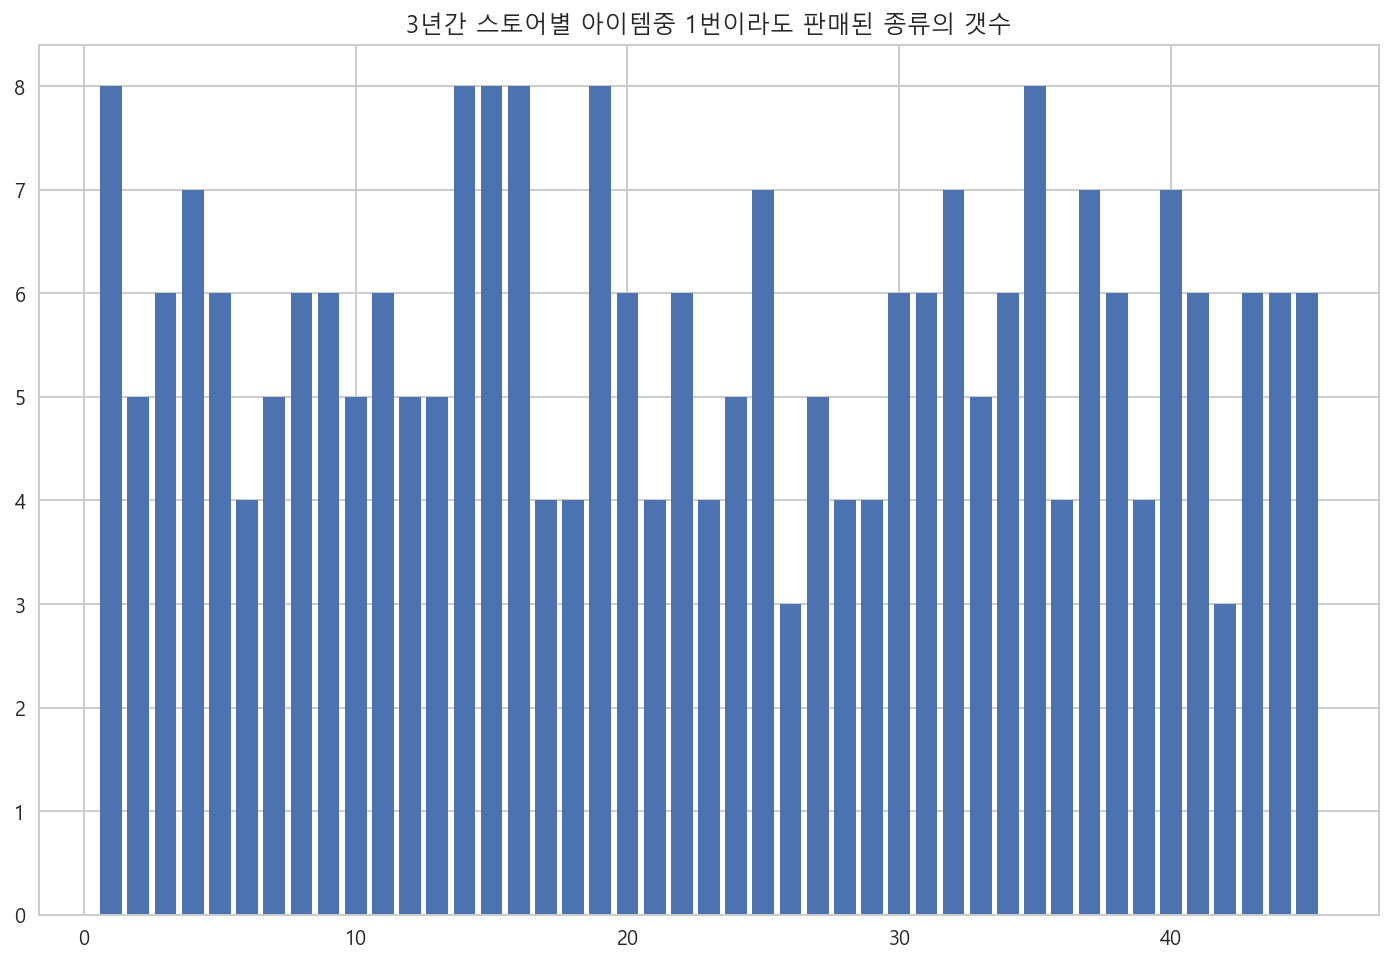

In [62]:
plt.figure(figsize=(12,8))
X = range(1,len(store_item["sales_items"]))
plt.title("3년간 스토어별 아이템중 1번이라도 판매된 종류의 갯수")
plt.bar(X,store_item["sales_items"][:45],label="sales_item")

plt.show()

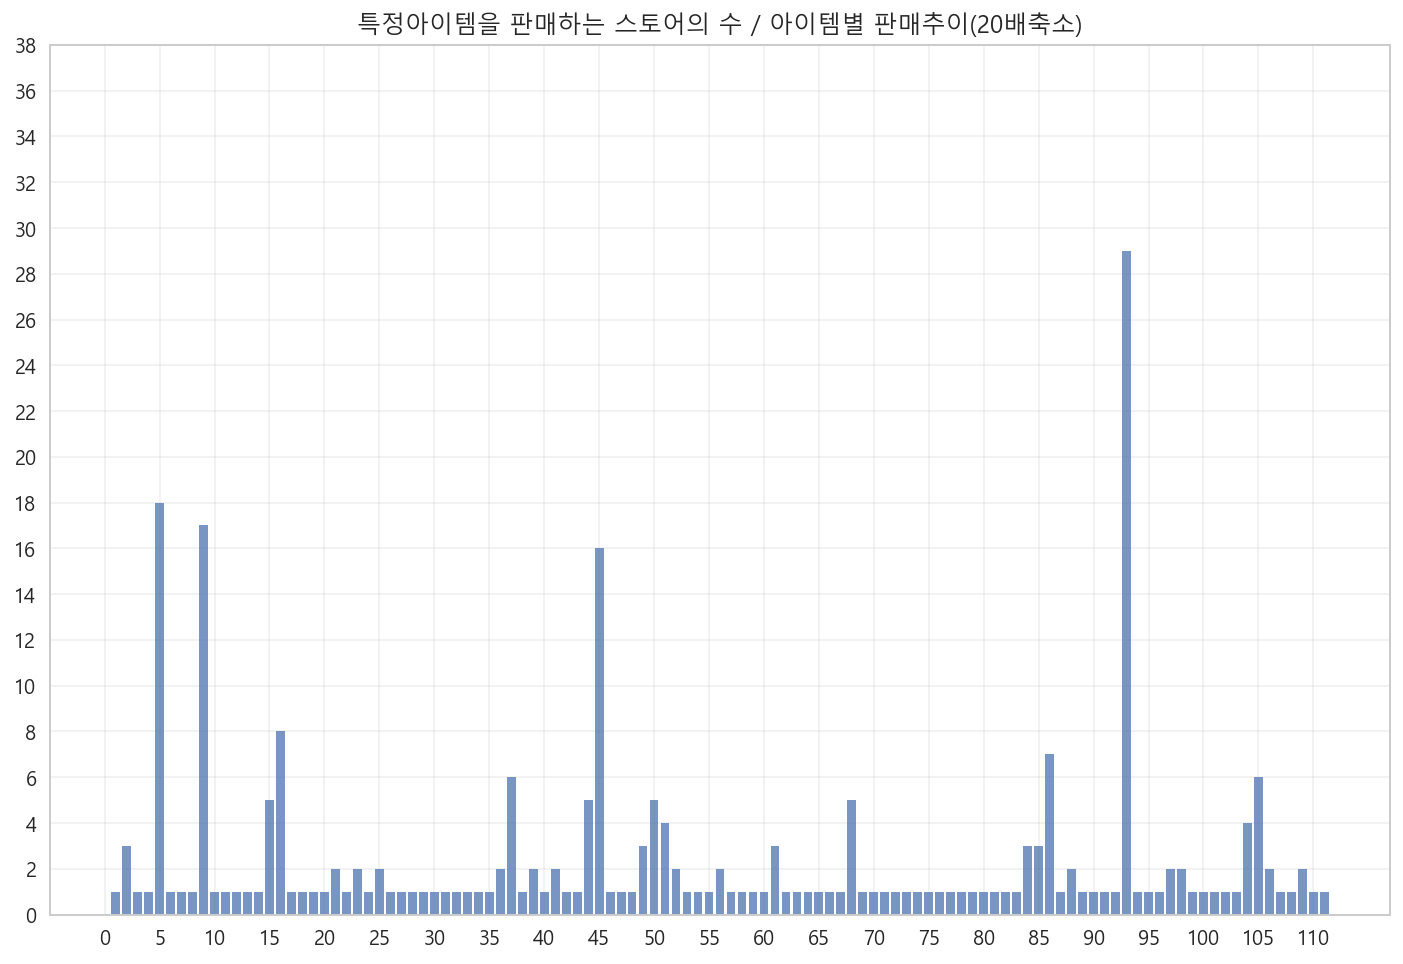

In [19]:
plt.figure(figsize=(12,8))
X = range(1,len(store_item.T[99]))
plt.title("특정아이템을 판매하는 스토어의 수 / 아이템별 판매추이(20배축소)")
plt.bar(X,store_item.T[99][:111],label="sales_item",alpha = 0.75)

plt.xticks(range(0,115,5))
plt.yticks(range(0,40,2))
plt.grid(alpha = 0.25)

# item_unit = master[(master["units"]<1000)&(master["units"]>0)]
# plt.scatter(item_unit["item_nbr"],item_unit["units"],c='r',alpha=0.1)

plt.show()

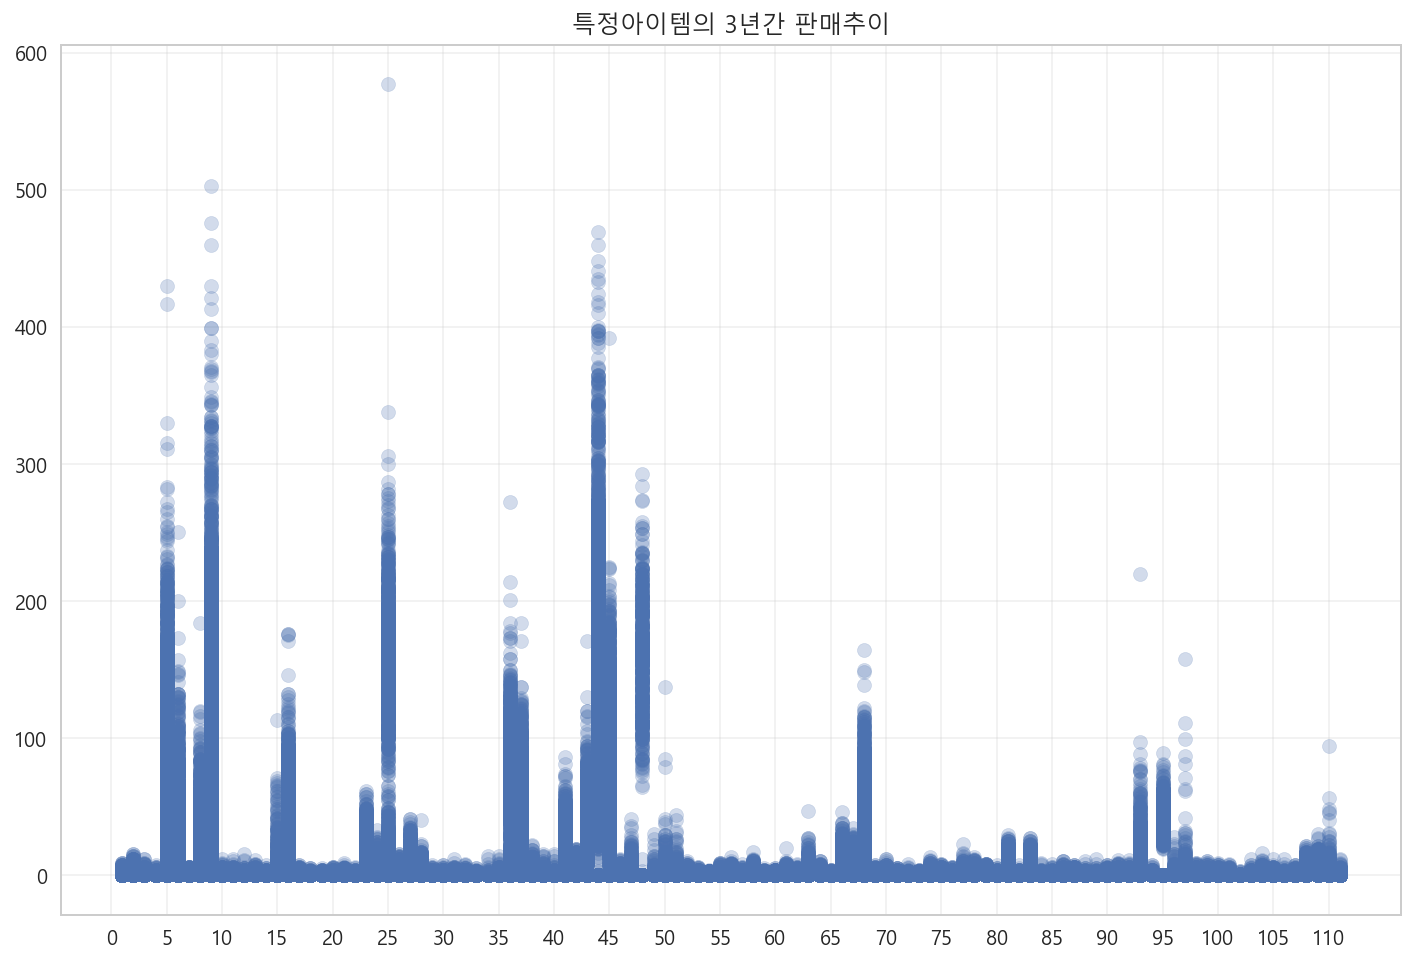

In [21]:
plt.figure(figsize=(12,8))
X = range(1,len(store_item.T[99]))
plt.title("특정아이템의 3년간 판매추이")
item_unit = master[master["units"]<1000]
plt.scatter(item_unit["item_nbr"],item_unit["units"],alpha=0.25)

plt.xticks(range(0,115,5))
# plt.yticks(range(0,40,2))
plt.grid(alpha = 0.25)

plt.show()

### - 전체기준 X아이템넘버/Y판매갯수 추이 

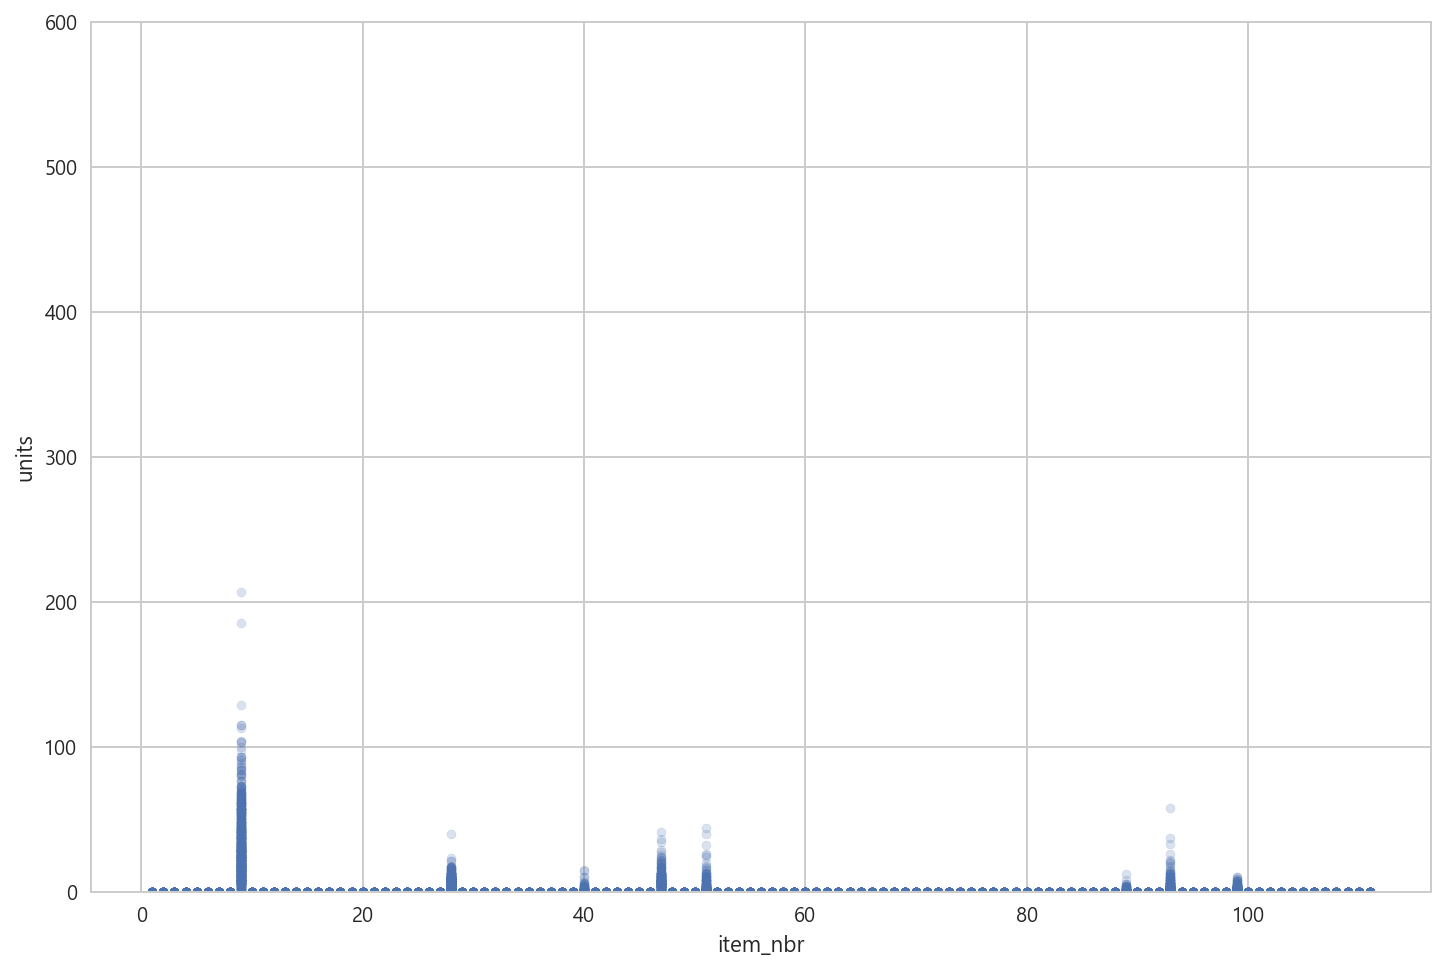

In [175]:
#각 아이템별 판매정도 추이
master[master["store_nbr"]==1].plot.scatter(x="item_nbr",y="units",figsize=(12,8),ylim=(0,600),alpha=0.2,style="hex")

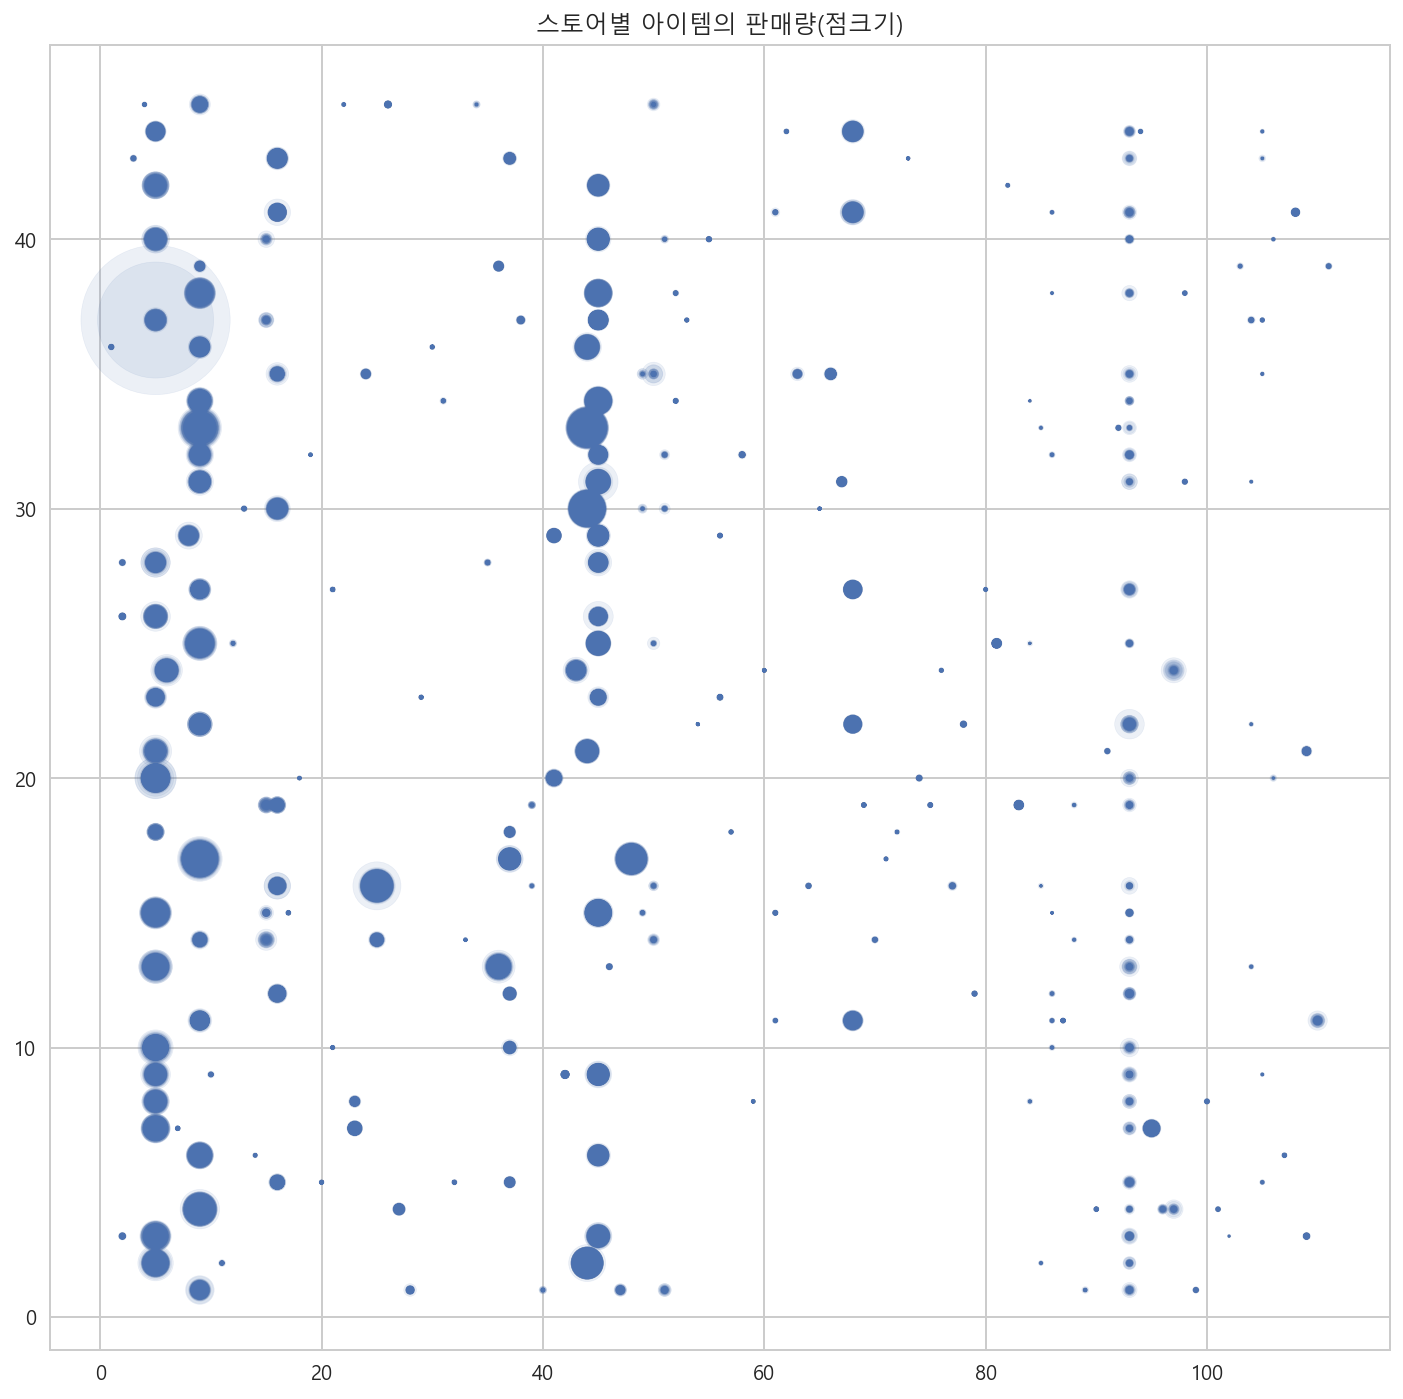

In [27]:
# 스토어, 아이템, 판매량(크기), 요일
plt.figure(figsize=(12,12))
x = master["item_nbr"]
y1 = master["store_nbr"]
# y2 = master["DOW"]
y3 = master["units"]
plt.grid(10)
plt.title("스토어별 아이템의 판매량(점크기)")
plt.scatter(x, y1, s=y3, alpha=0.1)
plt.show()

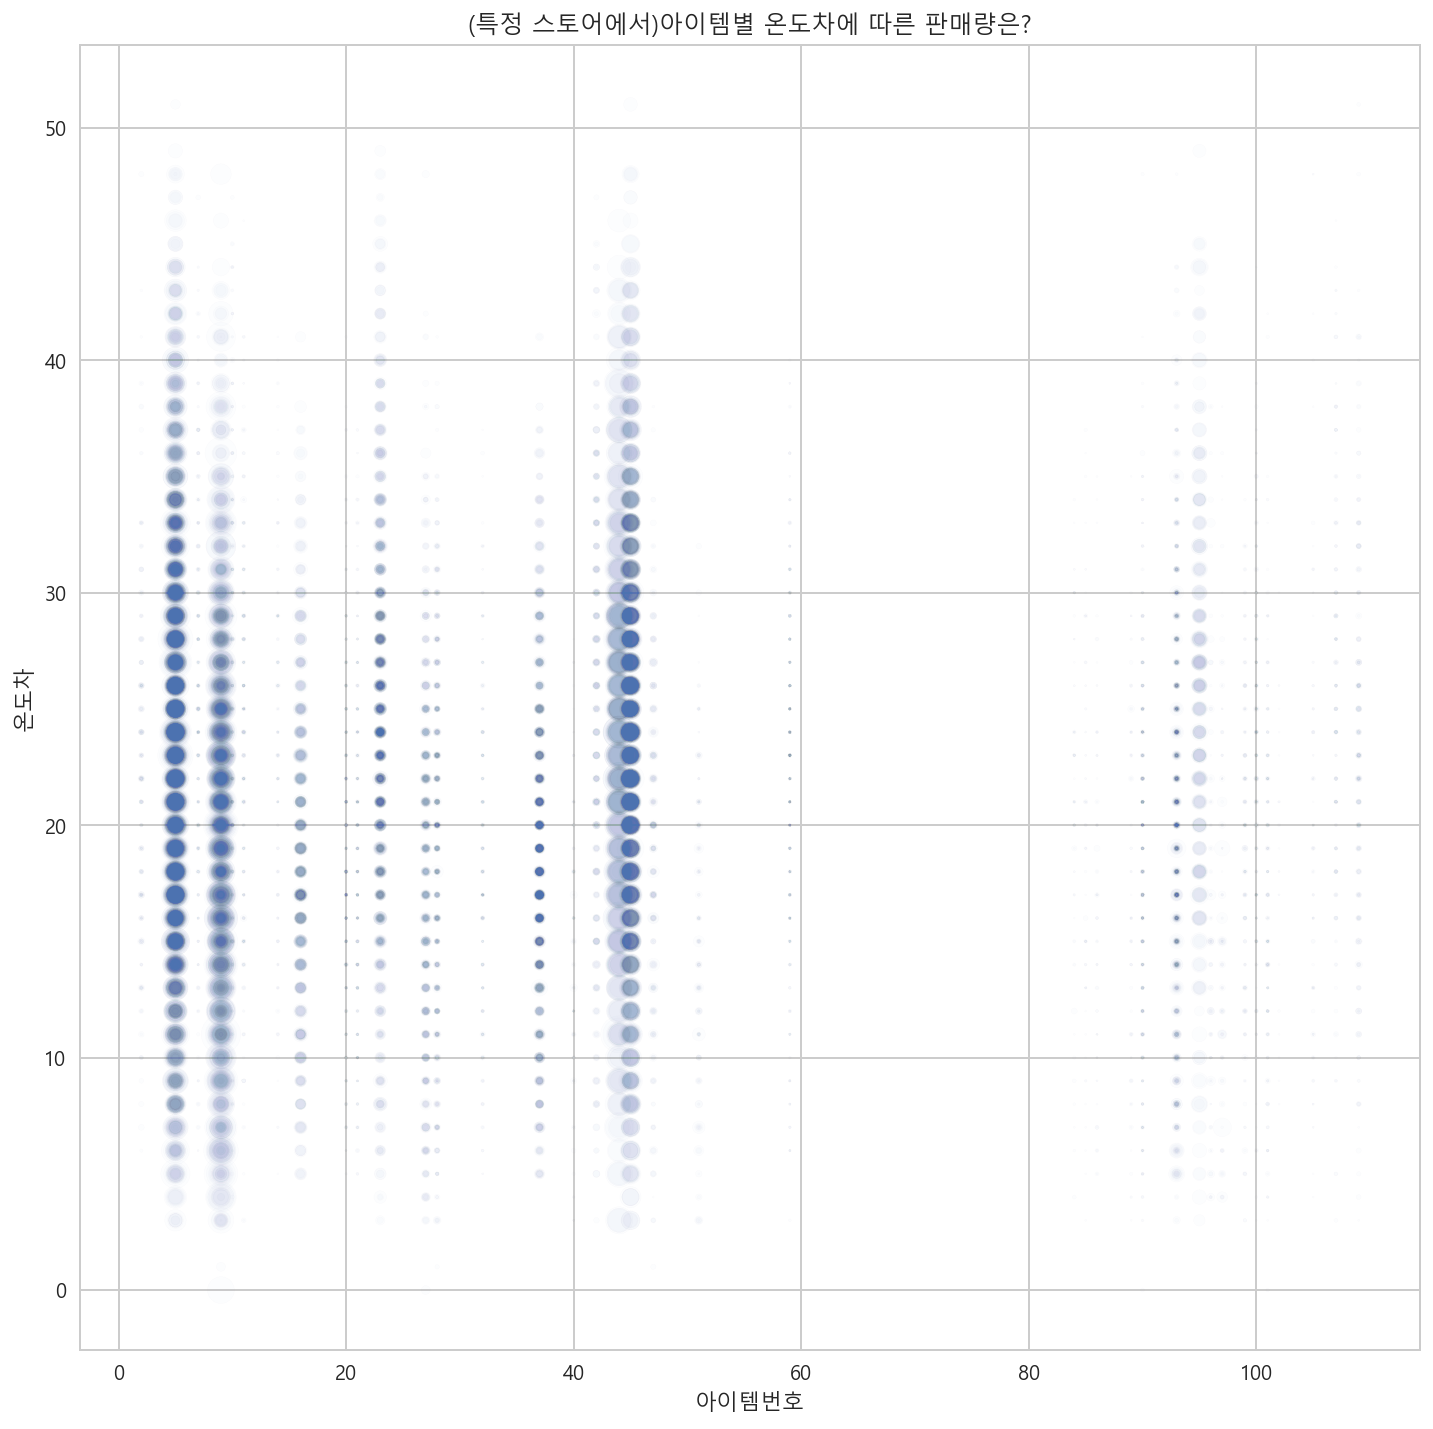

In [26]:
# 1차조건부 스토어, 아이템, 갯수, 요일, 온도차, 비의 여부 (빈도수가 높을수록 진하게 표시됨)
#  └-- scatter 등

#조건설정
cond = master[(master["store_nbr"]<=10)]

plt.figure(figsize=(12,12))
x = cond["item_nbr"]
y1 = cond["tdelta"]
# y2 = cond["DOW"]
y3 = cond["units"]
plt.xlabel("아이템번호")
plt.ylabel("온도차")
plt.title("(특정 스토어에서)아이템별 온도차에 따른 판매량은?")
plt.grid(10)
plt.scatter(x, y1, s=y3, alpha=0.01)
# plt.plot(x, y3 ,alpha=0.5)
# plt.bar(x,,alpha=0.1)
# plt.legend()
plt.show()

# 온도차에 따라서 많고적다기보다는 전체적인 분포는 비슷하기때문에 영향을 미치지 않는다고 판단된다.

### - 날씨코드에 따른 아이템 판매량

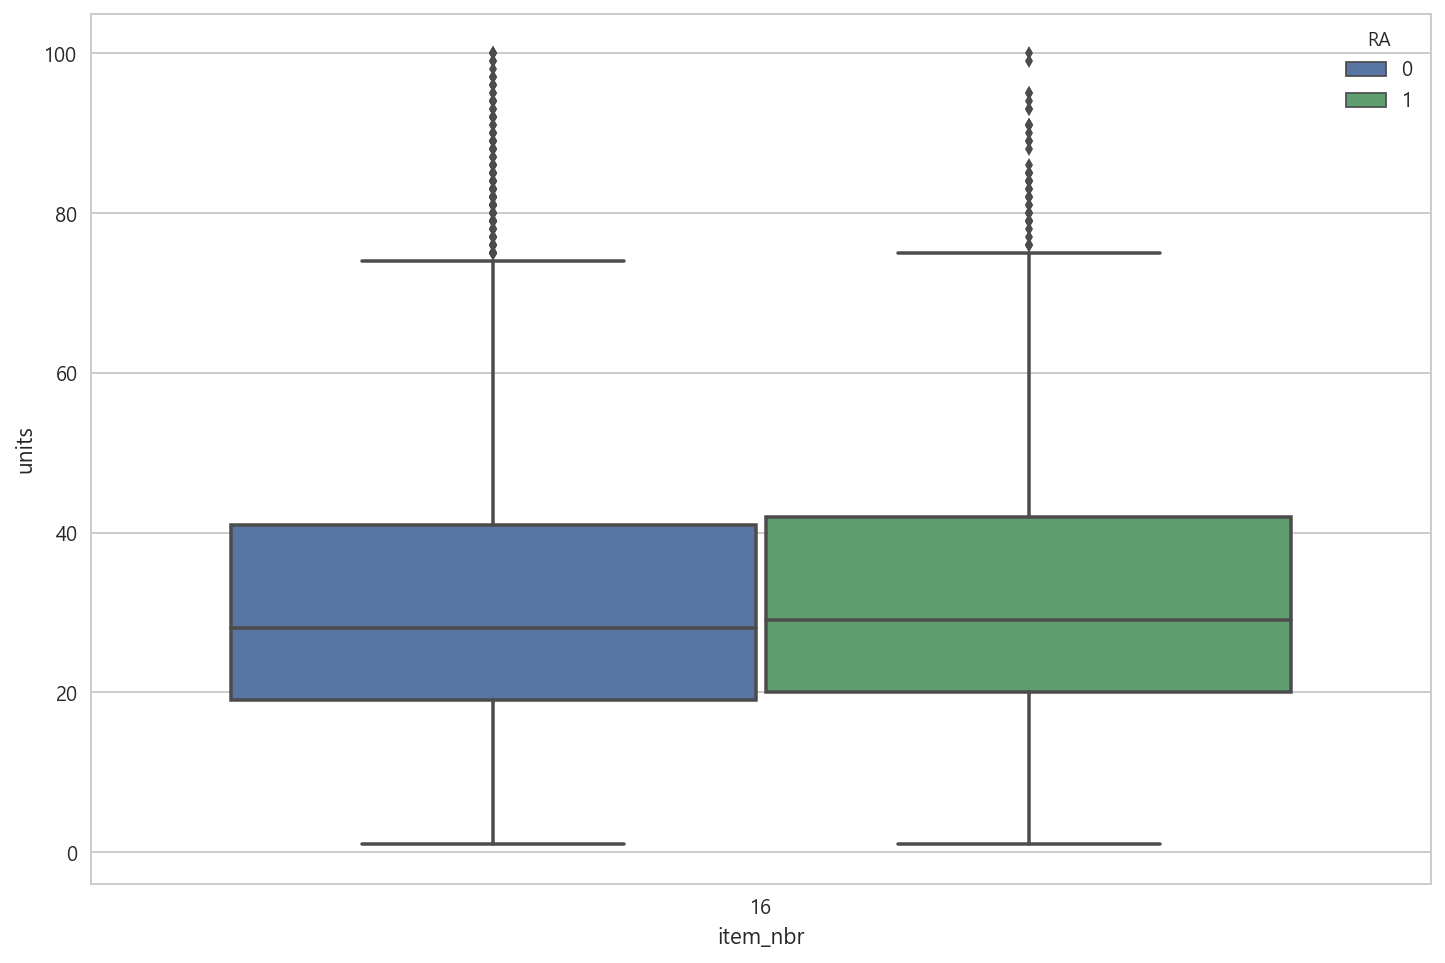

In [69]:
# 2차조건부 스토어, 아이템, 갯수, 요일 (빈도수가 높을수록 진하게 표시됨)
#  └-- hist, plot, bar 등

#조건설정
cond = master[(master["item_nbr"]==16)&(master["units"]<=100)&(master["units"]>0)]
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="item_nbr", y="units", hue="RA", data=cond)
# ["RA","BR","HZ","TS","FG","SN"]
plt.show()

# 특정한 아이템들은 특정날씨의 영향을 크게 받기도 한다.

---
# 시간분석(date / month / DOW)

### - 각 아이템넘버기준 X요일/Y판매량

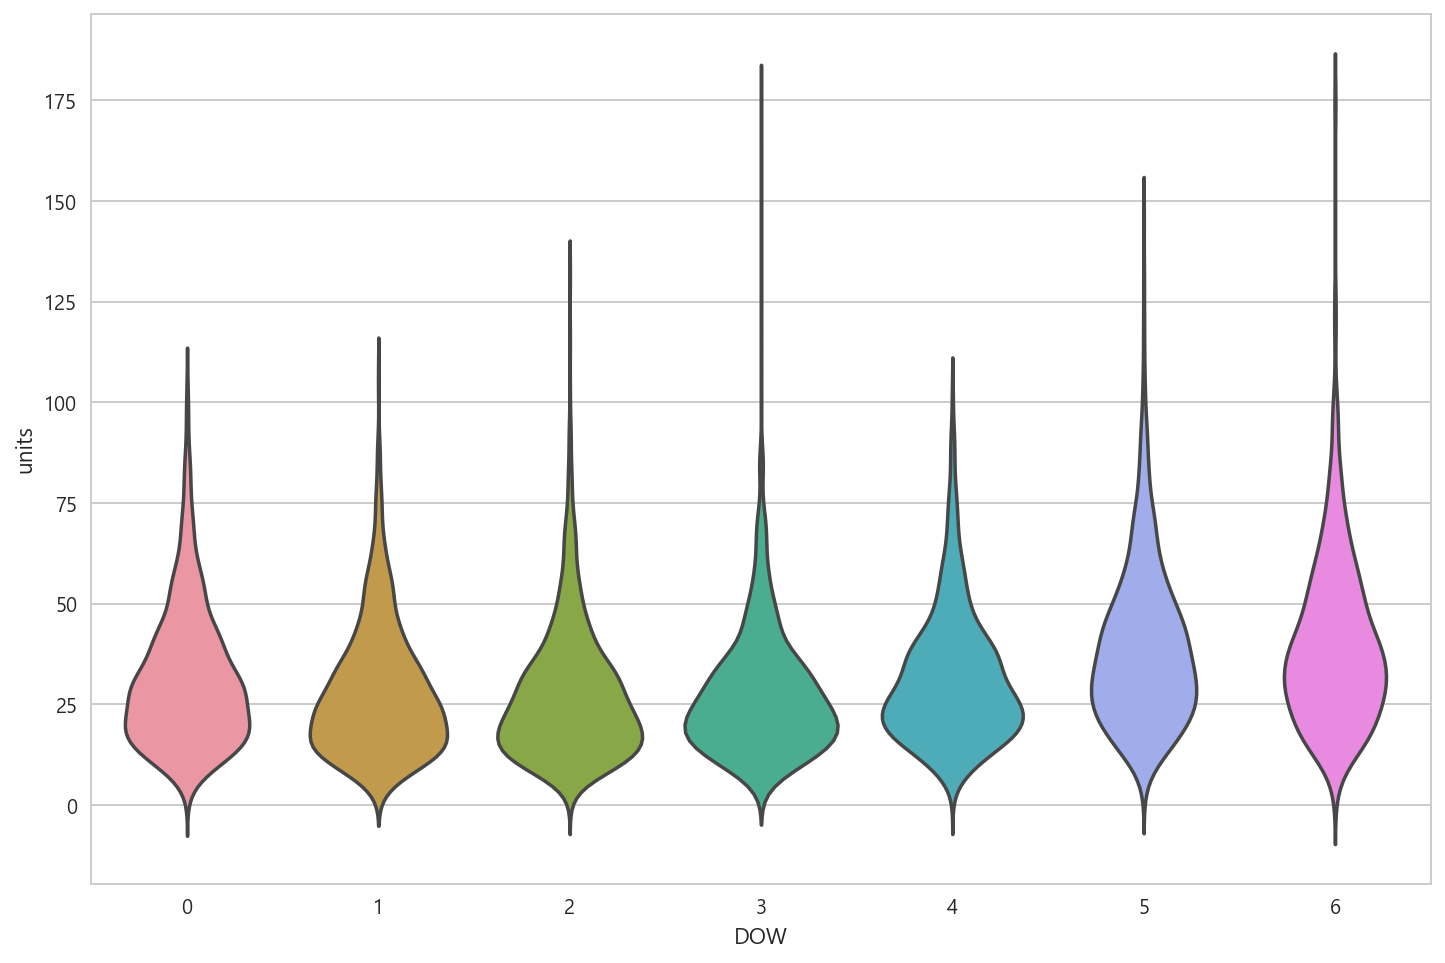

In [64]:
#대표적으로 2번아이템의 경우(팔린갯수 0인날 제외하면)
item2 = master[(master["item_nbr"]==16)&(master["units"]>0)&(master["units"]<2000)]
# item2.plot.scatter(x="preciptotal",y="units",figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="DOW", y="units", data=item2, inner=None)
# sns.swarmplot(ax=ax, x="DOW", y="units", data=item2, color="0.9")
plt.show()

### - 아이템 넘버기준 X시즌/Y판매량

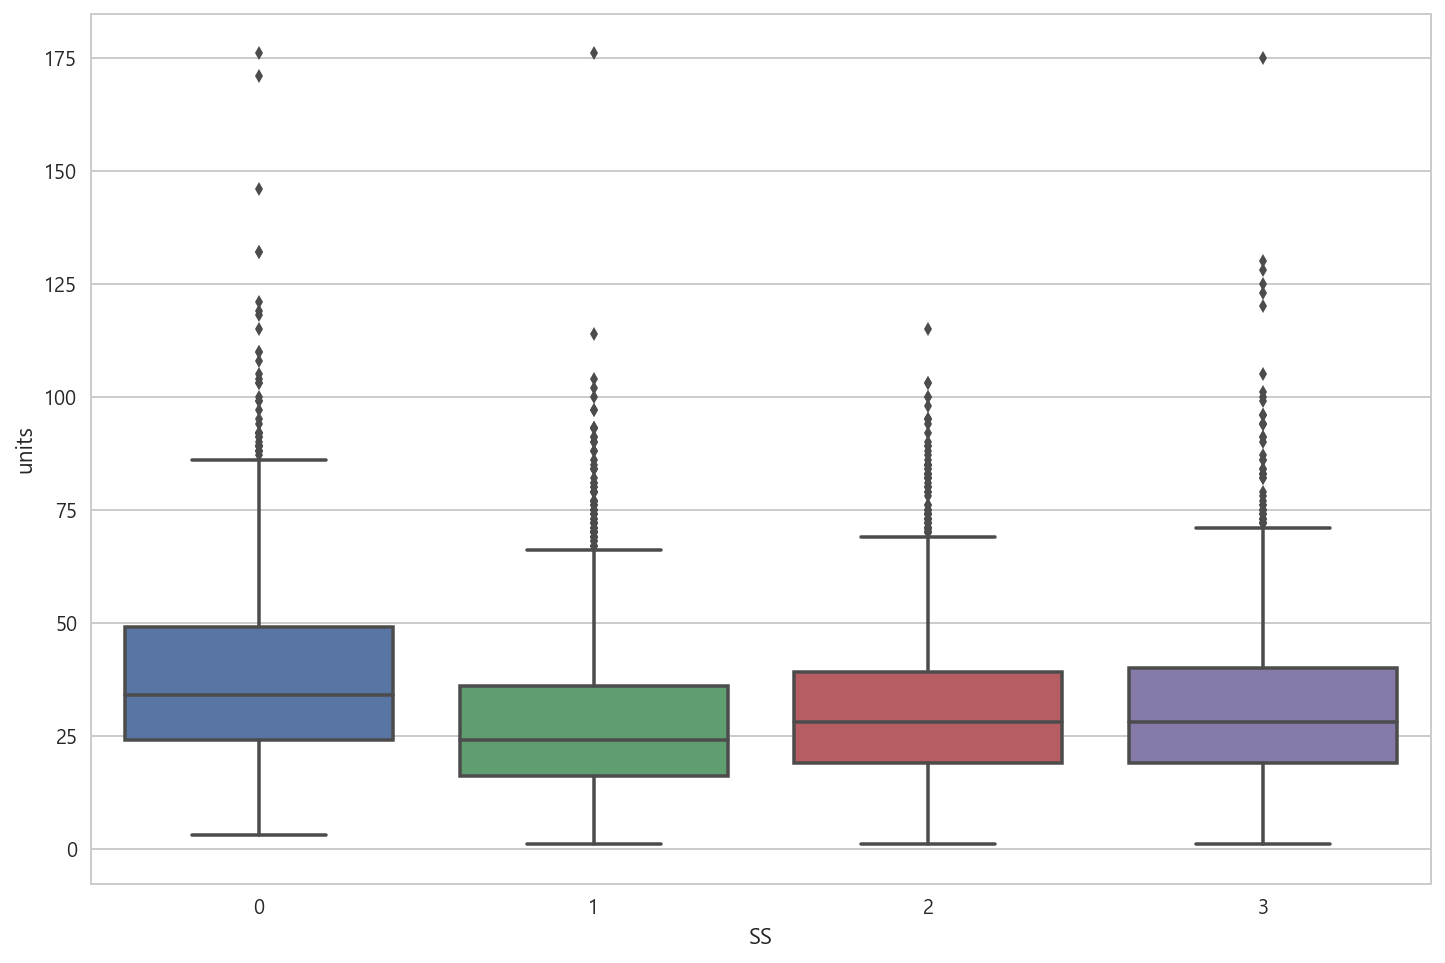

In [63]:
##### 각 아이템별 X시즌/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<300)&(master["item_nbr"]==16)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="SS", y="units", data=item_n)
plt.show()

### - 각 아이템넘버기준 X월별/Y판매량

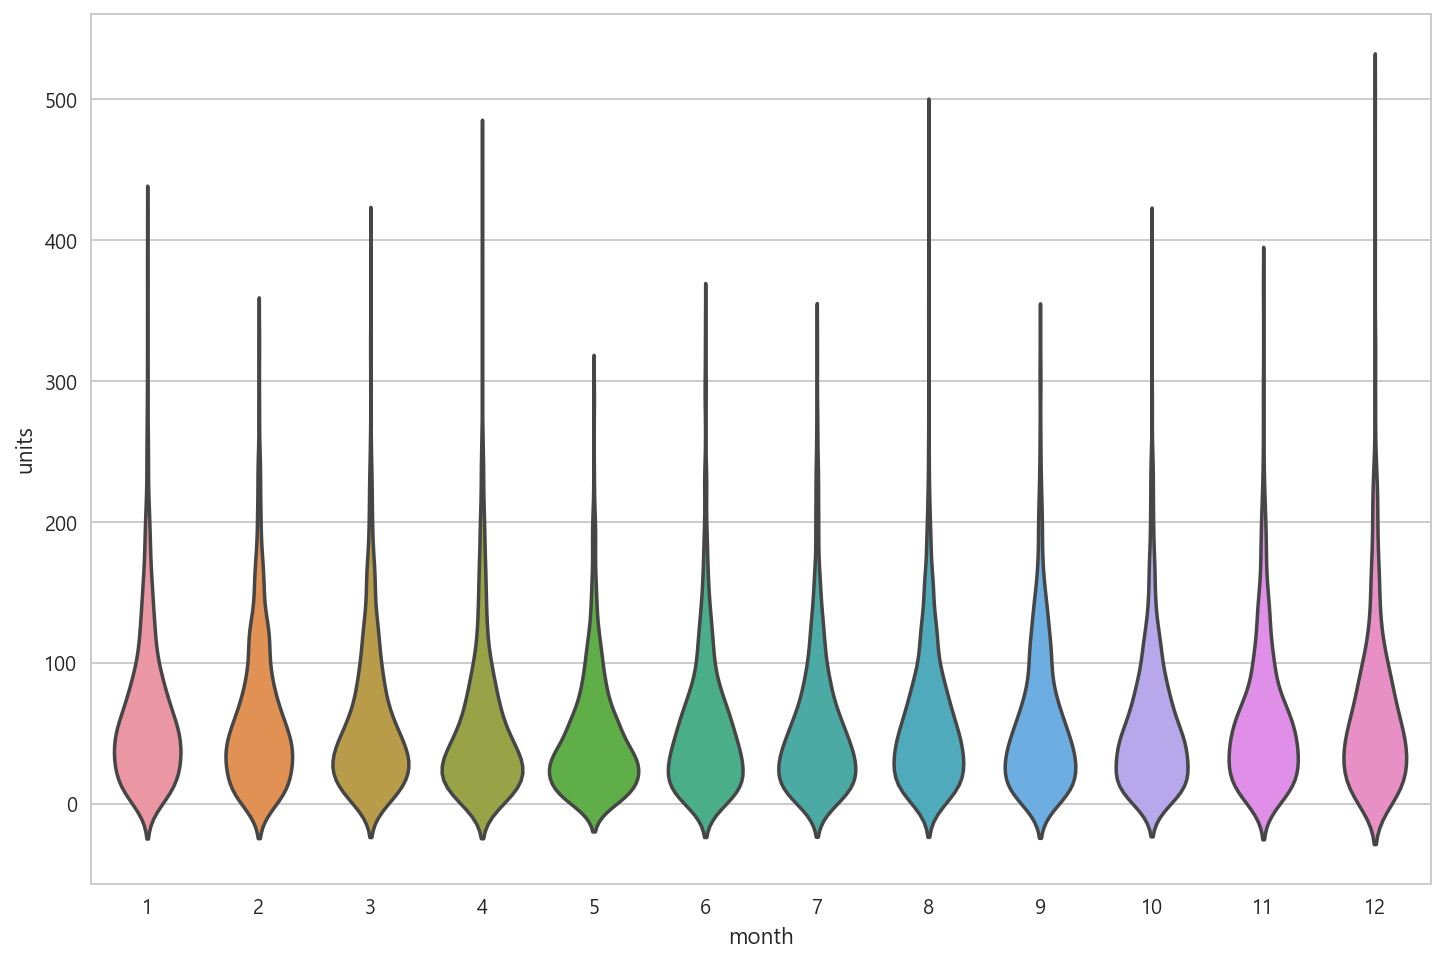

In [58]:
#각 아이템별 X월/Y판매량
item_n = master[(master["item_nbr"]==9)&(master["units"]<2000)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="month", y="units", data=item_n, inner=None)
plt.show()

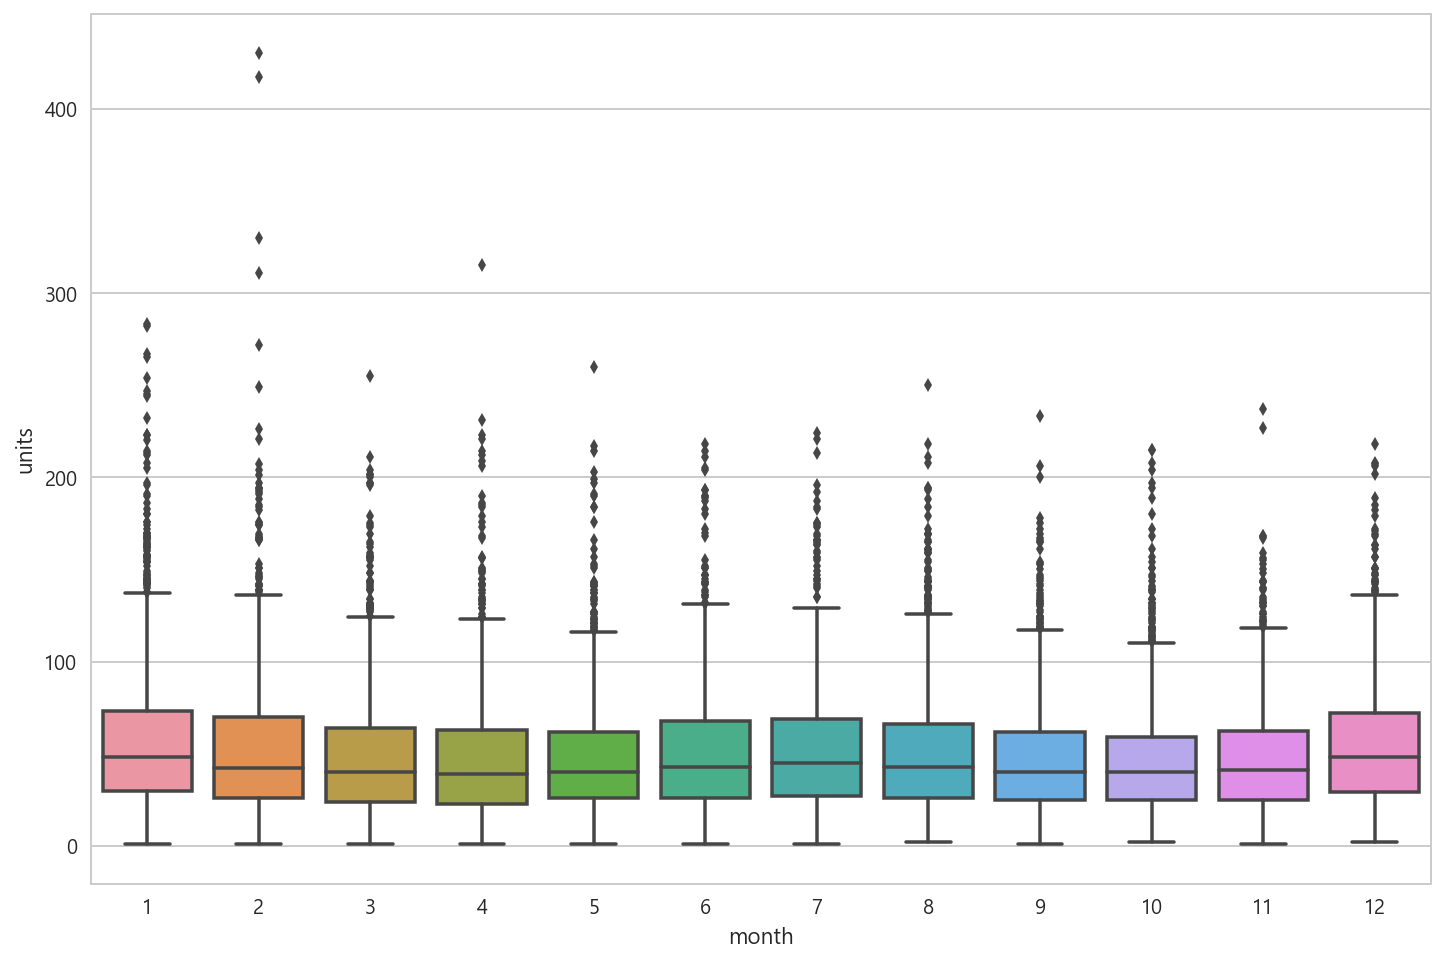

In [22]:
### 각 아이템별 X월/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<2000)&(master["item_nbr"]==5)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="month", y="units", data=item_n)
plt.show()

### - 각 아이템별 X일/Y판매량

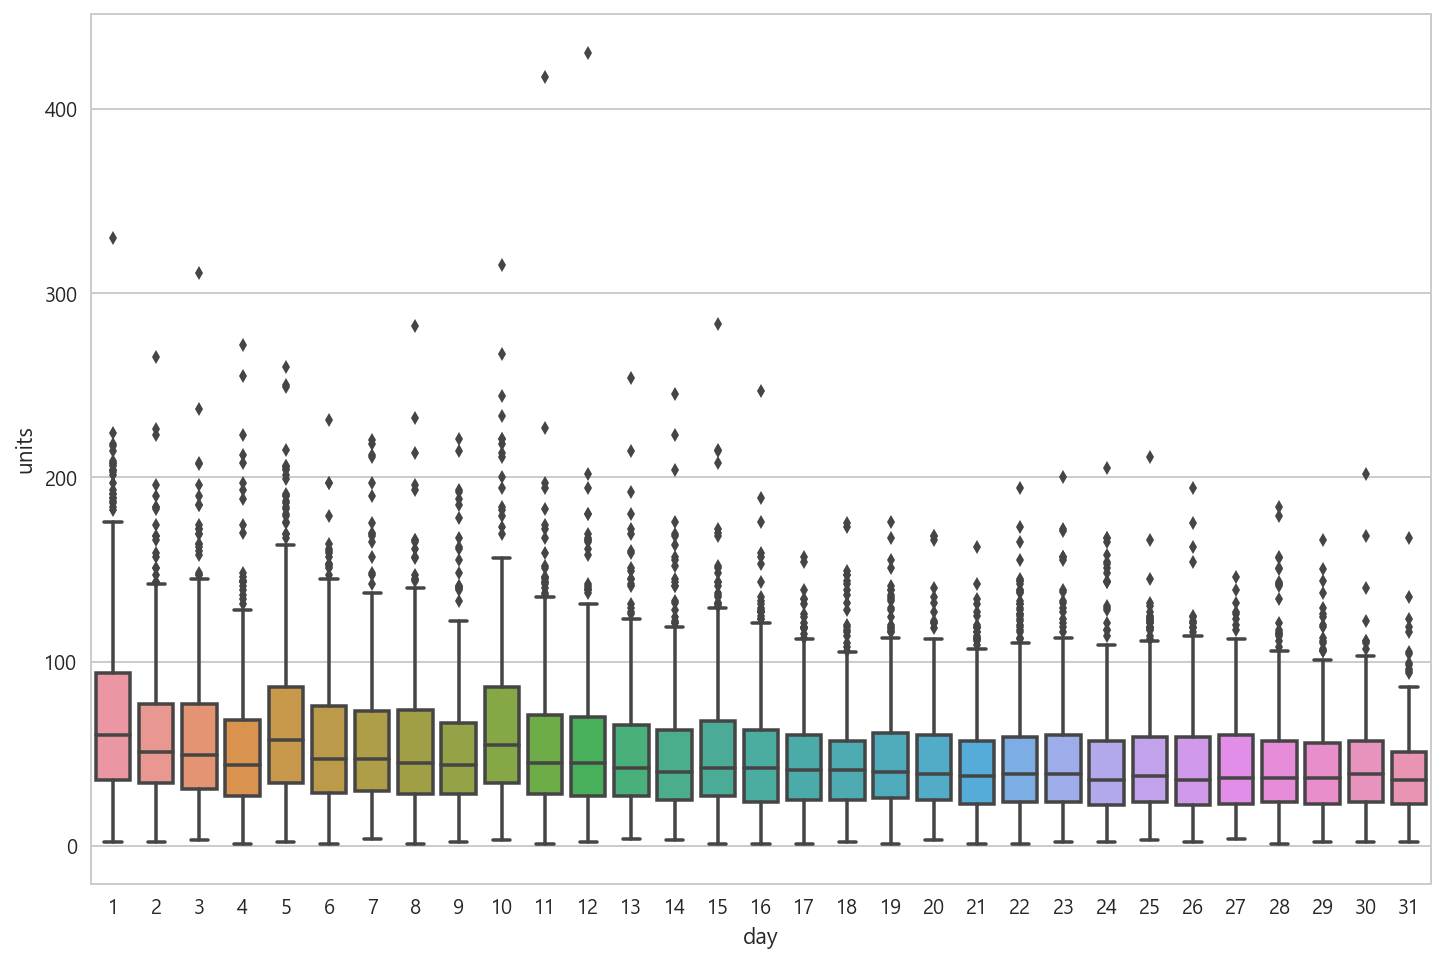

In [25]:
#각 아이템별 X일/Y판매량
item_n = master[(master["units"]>0)&(master["units"]<1500)&(master["item_nbr"]==5)]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="day", y="units", data=item_n)
plt.show()

# 날씨별분석

### - 날씨코드정렬

In [145]:
count_code = master.groupby("codesum").size().reset_index(name="counts")
count_code.sort_values("counts", ascending=False).reset_index(drop=True).head(10)

codesum  counts
0               65560
1          BR    8079
2          RA    7982
3       RA BR    7522
4       BR HZ    2094
5       SN BR    1865
6          HZ    1859
7  TSRA RA BR    1415
8          TS    1411
9        TSRA     895

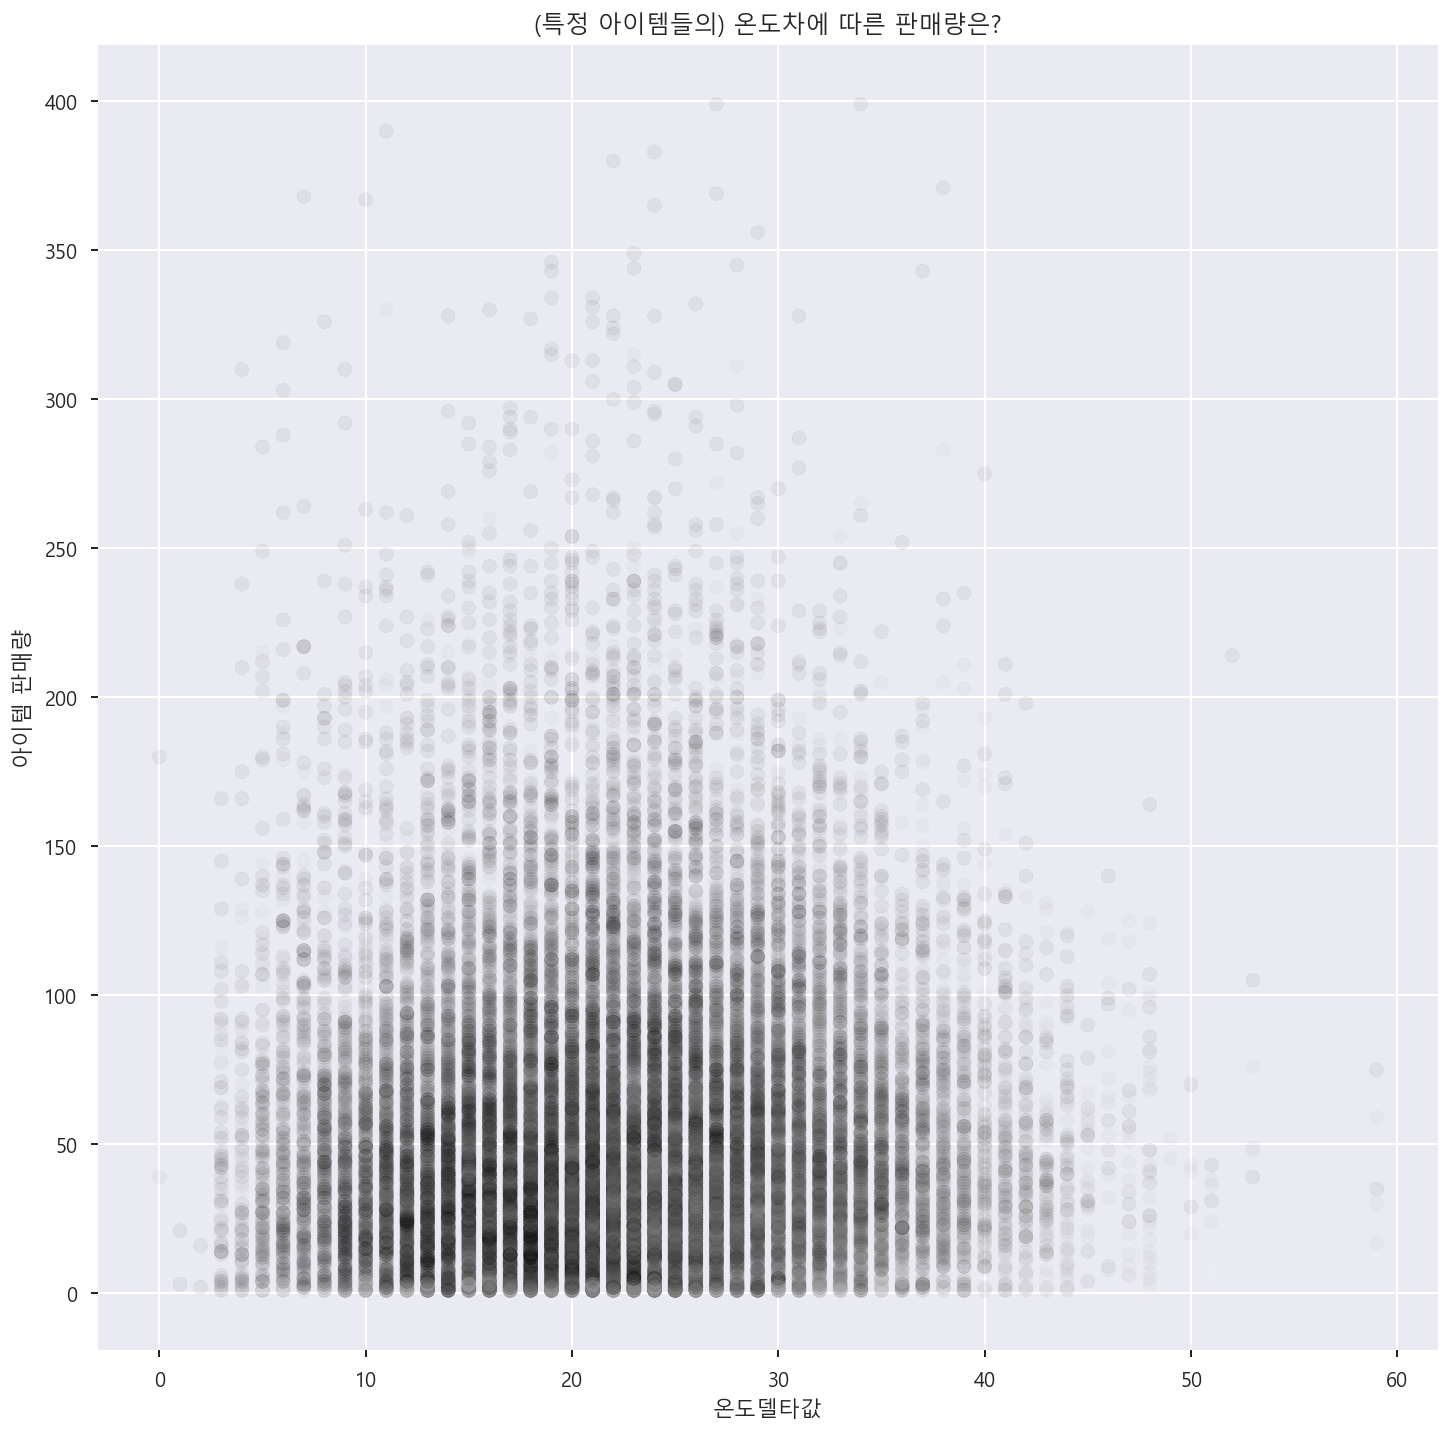

In [156]:
# 1차조건부 스토어, 아이템, 갯수, 요일, 온도차, 비의 여부 (빈도수가 높을수록 진하게 표시됨)
#  └-- scatter 등

#조건설정
cond = master[(master["item_nbr"]<=9)&(master["units"]<400)]

plt.figure(figsize=(12,12))
c = cond["item_nbr"]
x = cond["tdelta"]
# y2 = cond["DOW"]
y1 = cond["units"]
plt.scatter(x, y1, c=c, alpha=0.05)
plt.xlabel("온도델타값")
plt.ylabel("아이템 판매량")
plt.title("(특정 아이템들의) 온도차에 따른 판매량은?")
# plt.xticks(10)
# plt.yticks(10)
# plt.grid()
plt.show()

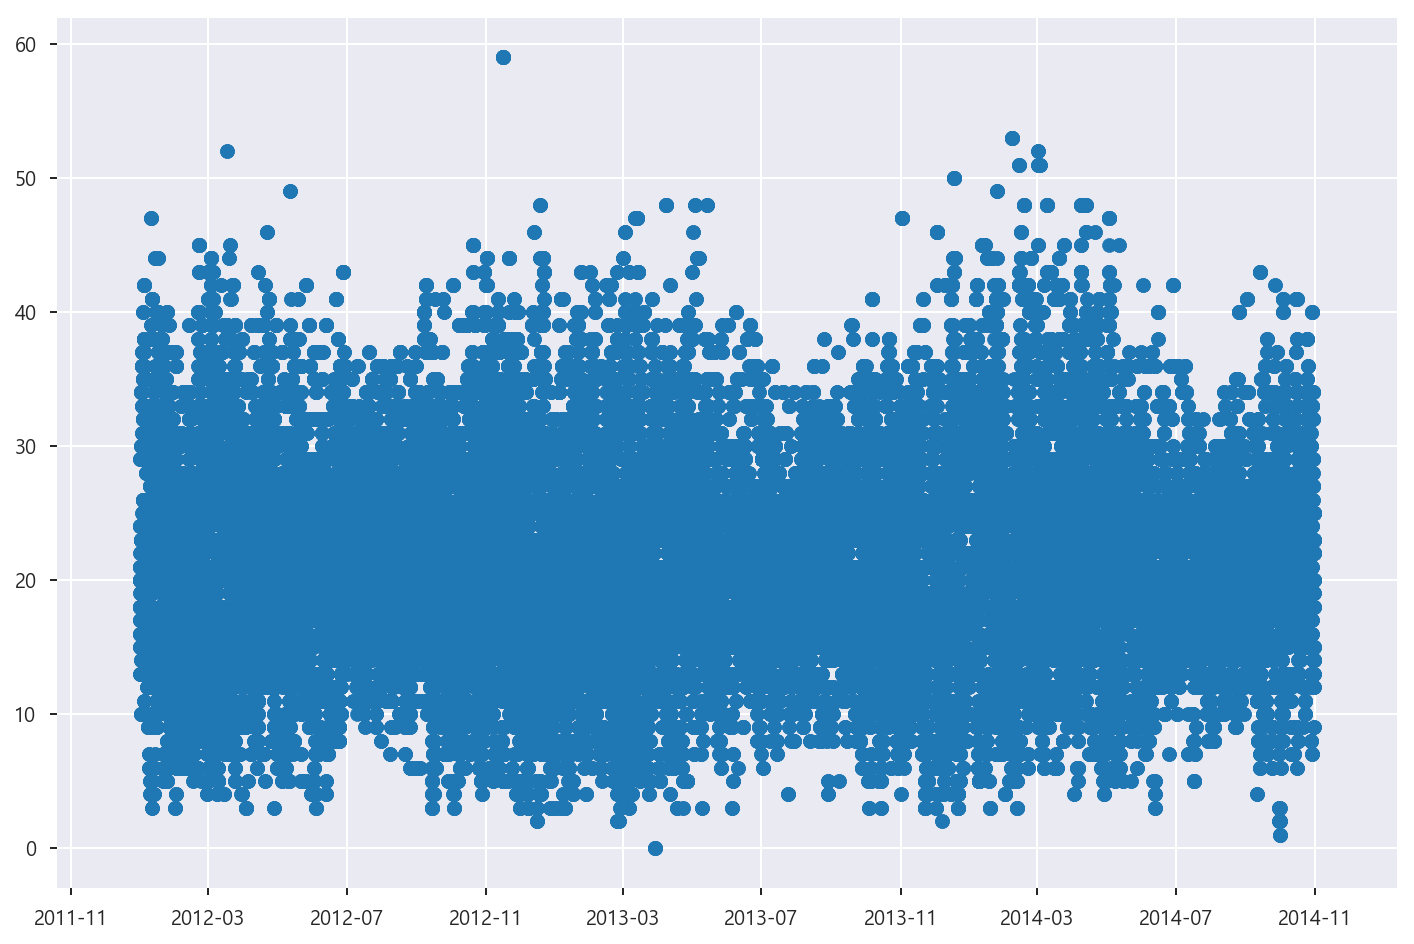

In [158]:
#델타값의 날짜별 스캐터링
plt.figure(figsize=(12,8))
X = [pd.to_datetime(d) for d in master['date']]
plt.scatter(X,master["tdelta"])

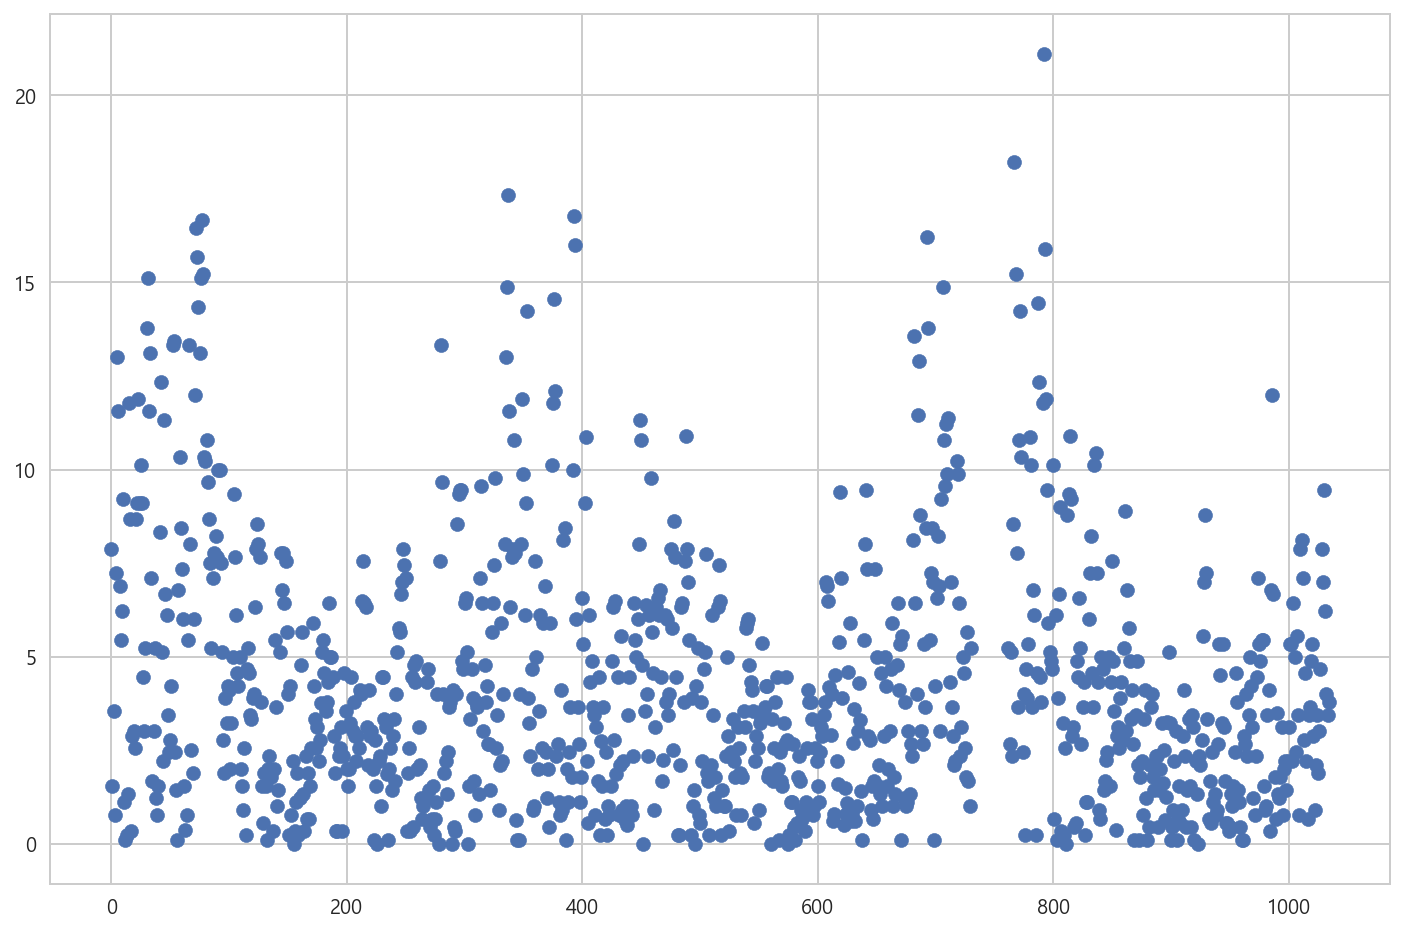

In [38]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart_avg)),abs(station_depart_avg))

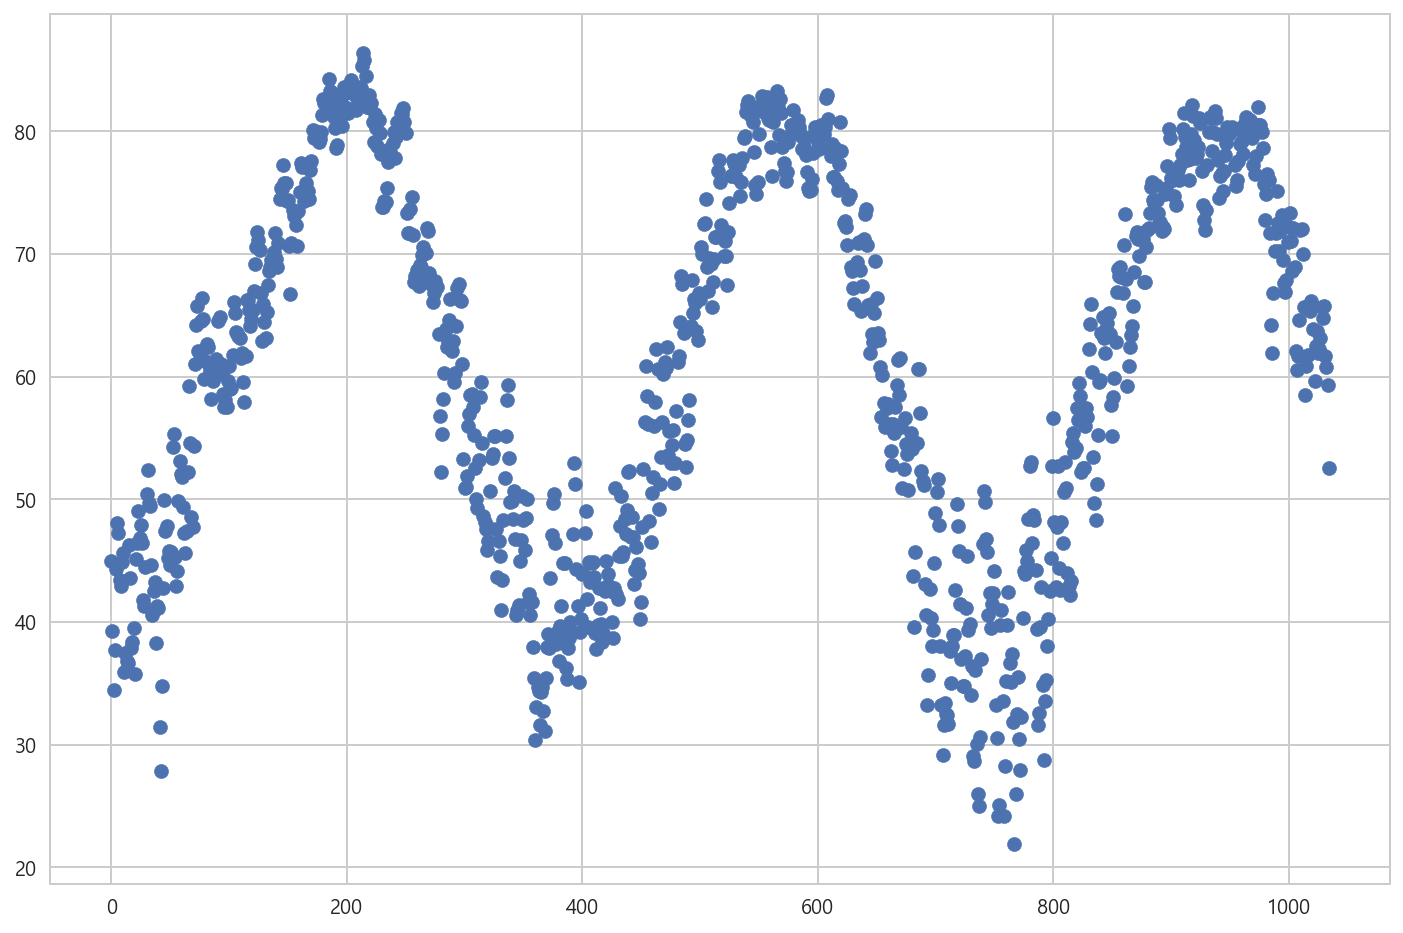

In [40]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_temp_avg)),abs(station_temp_avg))

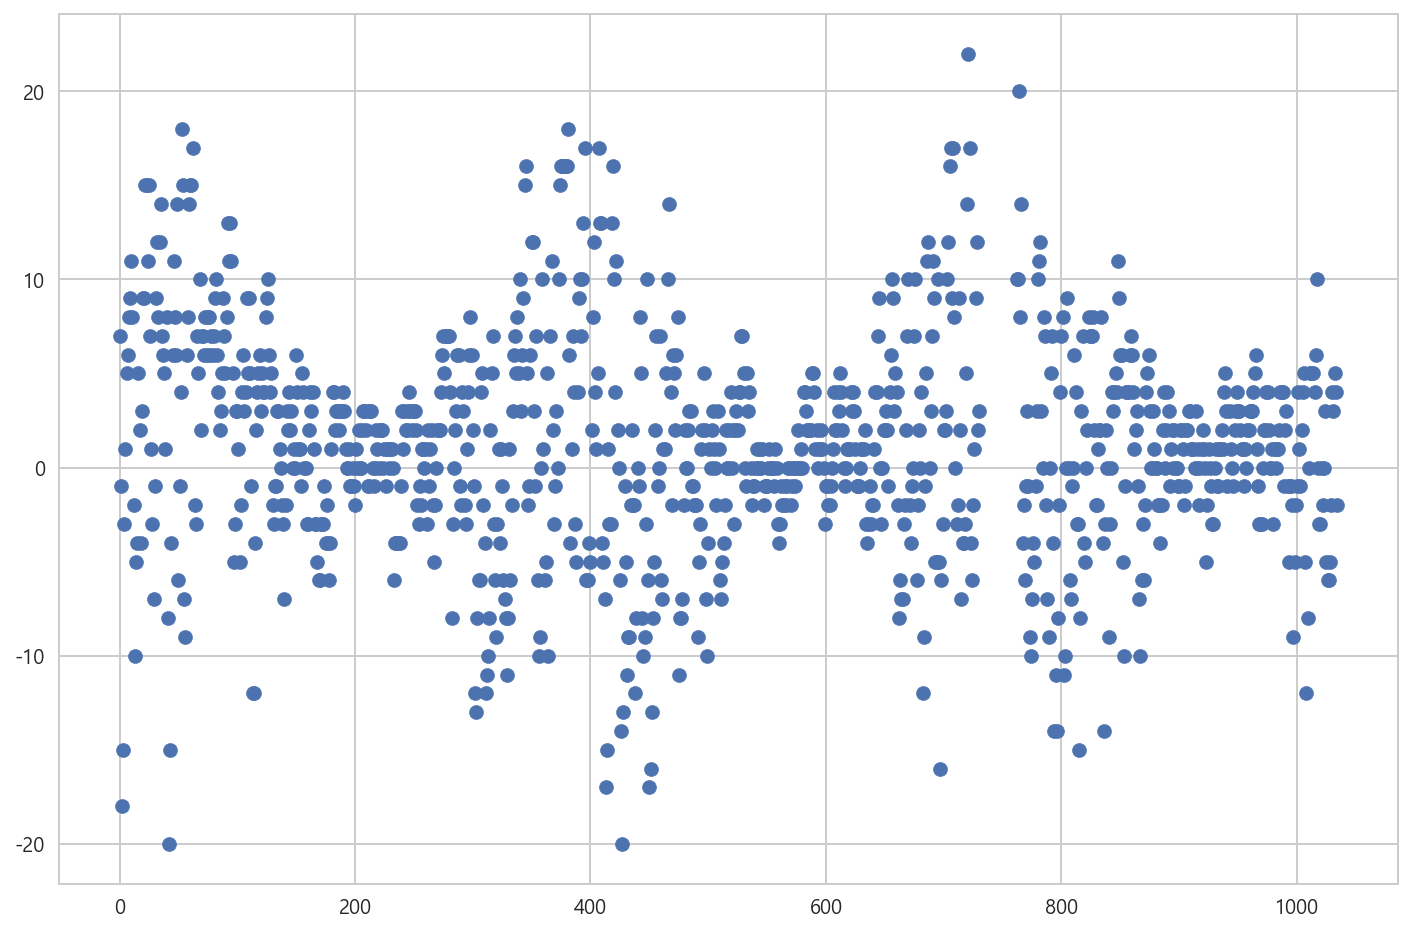

In [342]:
#일부 스테이션 depart의 분포
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart)),station_depart[11])

In [139]:
k = master[(master["snowfall"]==0)&(master["SN"]==1)].reset_index()
k[["SN","snowfall"]]

SN  snowfall
0      1       0.0
1      1       0.0
2      1       0.0
3      1       0.0
4      1       0.0
5      1       0.0
6      1       0.0
7      1       0.0
8      1       0.0
9      1       0.0
10     1       0.0
11     1       0.0
12     1       0.0
13     1       0.0
14     1       0.0
15     1       0.0
16     1       0.0
17     1       0.0
18     1       0.0
19     1       0.0
20     1       0.0
21     1       0.0
22     1       0.0
23     1       0.0
24     1       0.0
25     1       0.0
26     1       0.0
27     1       0.0
28     1       0.0
29     1       0.0
...   ..       ...
2412   1       0.0
2413   1       0.0
2414   1       0.0
2415   1       0.0
2416   1       0.0
2417   1       0.0
2418   1       0.0
2419   1       0.0
2420   1       0.0
2421   1       0.0
2422   1       0.0
2423   1       0.0
2424   1       0.0
2425   1       0.0
2426   1       0.0
2427   1       0.0
2428   1       0.0
2429   1       0.0
2430   1       0.0
2431   1       0.0
2432   1       0.0
2433   1       0.0
2434   1       0.0
2435   1       0.0
2436   1       0.0
2437   1       0.0
2438   1       0.0
2439   1       0.0
2440   1       0.0
2441   1       0.0

[2442 rows x 2 columns]

In [ ]:
g = sns.PairGrid(master, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

# 6. 아웃라이어 및 레버리지 판단

In [17]:
store_item.tail()

item_nbr   1  2    3    4      5  6  7  8      9  10     ...       103  104  \
store_nbr                                                ...                  
42         0  0    0    0  35178  0  0  0      0   0     ...         0    0   
43         0  0  675    0      0  0  0  0      0   0     ...         0    0   
44         0  0    0    0  32834  0  0  0      0   0     ...         0    0   
45         0  0    0  348      0  0  0  0  15833   0     ...         0    0   
99         1  3    1    1     18  1  1  1     17   1     ...         1    4   

item_nbr   105  106  107  108  109  110  111  sales_items  
store_nbr                                                  
42           0    0    0    0    0    0    0            3  
43          72    0    0    0    0    0    0            6  
44          83    0    0    0    0    0    0            6  
45           0    0    0    0    0    0    0            6  
99           6    2    1    1    2    1    1           45  

[5 rows x 112 columns]

In [17]:
master.columns

Index(['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units', 'tmax', 'tmin',
       'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise',
       'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure',
       'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'tdelta', 'RA',
       'BR', 'HZ', 'TS', 'FG', 'SN', 'year', 'month', 'day', 'DOW', 'SS'],
      dtype='object')

In [143]:
import statsmodels.api as sm

ms_df = master[(master["store_nbr"]==4)&(master["item_nbr"]==9)]


# dfX=pd.DataFrame(ms_df, columns=['tavg', 'snowfall', 'preciptotal', 'stnpressure',
#        'avgspeed', 'tdelta']).dropna()
# 'RA', 'BR', 'HZ', 'TS', 'FG', 'SN', 'year', 'month', 'day', 'DOW'])
msdf= ms_df[['units','tavg', 'preciptotal', 'stnpressure','DOW','day','month','year','SS','tmax','tmin','tdelta','RA','FG','BR','TS','SN']].dropna()
model_wm = sm.OLS(msdf[['units']],msdf[['tavg','DOW','SS','RA','FG','BR','TS','SN','tdelta']])
result_wm = model_wm.fit()
print(result_wm.summary())
# ms_df[['tavg', 'preciptotal', 'stnpressure']]

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     434.0
Date:                Sat, 30 Jun 2018   Prob (F-statistic):               0.00
Time:                        20:58:05   Log-Likelihood:                -5160.3
No. Observations:                 939   AIC:                         1.034e+04
Df Residuals:                     930   BIC:                         1.038e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tavg           0.0883      0.112      0.791      0.4

In [144]:
model2 = sm.OLS.from_formula("units ~ C(FG) + C(RA) + C(TS) + C(BR) + C(SN) + scale(tavg) + scale(tdelta) + scale(preciptotal) + 0", data=msdf)
print(model2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  units   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.118
Date:                Sat, 30 Jun 2018   Prob (F-statistic):            0.00175
Time:                        20:59:01   Log-Likelihood:                -5100.7
No. Observations:                 939   AIC:                         1.022e+04
Df Residuals:                     930   BIC:                         1.026e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(FG)[0]             122.2016      2

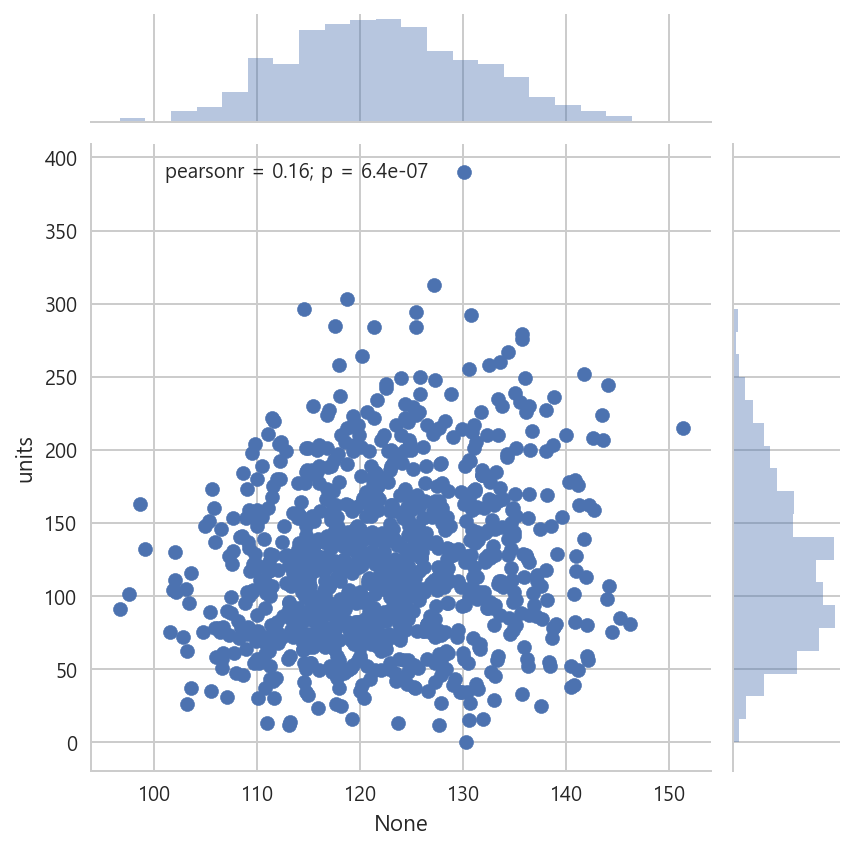

In [145]:
sns.jointplot(model2.fit().fittedvalues, msdf["units"])
plt.show()

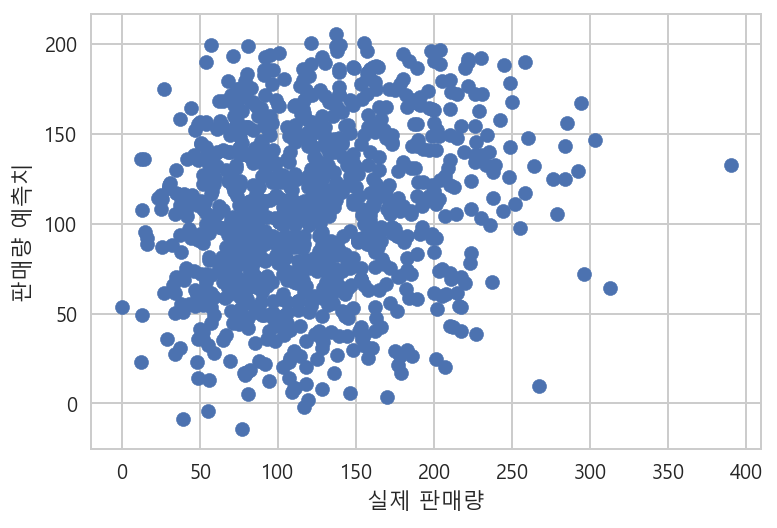

In [109]:
predictms = result_wm.predict(msdf[['tavg','DOW','SS','RA']])

plt.scatter(msdf[["units"]], predictms)
plt.xlabel(u"실제 판매량")
plt.ylabel(u"판매량 예측치")
plt.show()

In [110]:
# 표준화잔차가 2 이상인 경우 아웃라이어로 규정하면
idx = result_wm.resid_pearson > 2
msdf[idx].tail()

units  tavg  preciptotal  stnpressure  DOW  day  month  year  SS  \
959159    276  10.0        0.000        29.47    6   23      2  2014   0   
960935    146   0.0        0.005        29.63    0    3      3  2014   1   
961379    205  17.0        0.000        29.62    2    5      3  2014   1   
965153    258  16.0        0.000        29.67    5   22      3  2014   1   
975143    237  48.0        0.000        29.31    1   13      5  2014   1   

        tmax  tmin  RA  
959159  18.0   2.0   0  
960935  10.0 -11.0   0  
961379  23.0  11.0   0  
965153  23.0   9.0   0  
975143  53.0  43.0   0

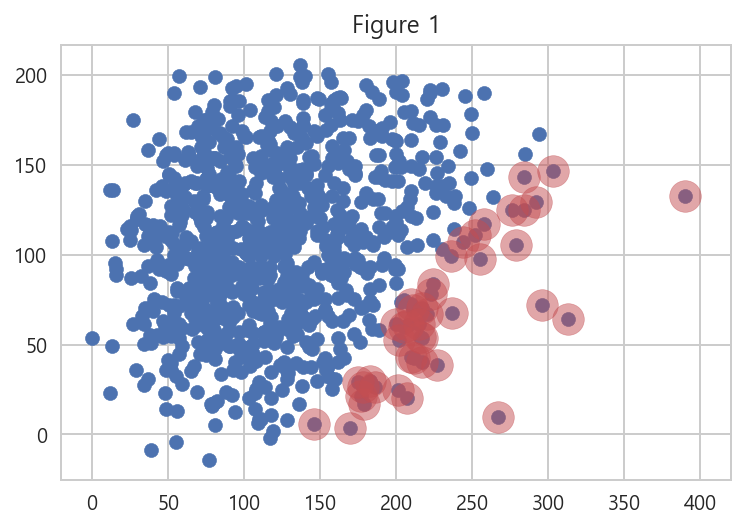

In [111]:
plt.scatter(msdf.units, predictms)
plt.scatter(msdf[idx].units, predictms[idx], s=250, c='r', alpha=0.5)
plt.title("Figure 1")
plt.show()


In [112]:
#레버리지를 평균레버리지의 3배이상으로 볼 경우
influence = result_wm.get_influence()
hat = influence.hat_matrix_diag

idx = hat > 3 * hat.mean()
msdf[idx].tail()

Empty DataFrame
Columns: [units, tavg, preciptotal, stnpressure, DOW, day, month, year, SS, tmax, tmin, RA]
Index: []

<Container object of 3 artists>

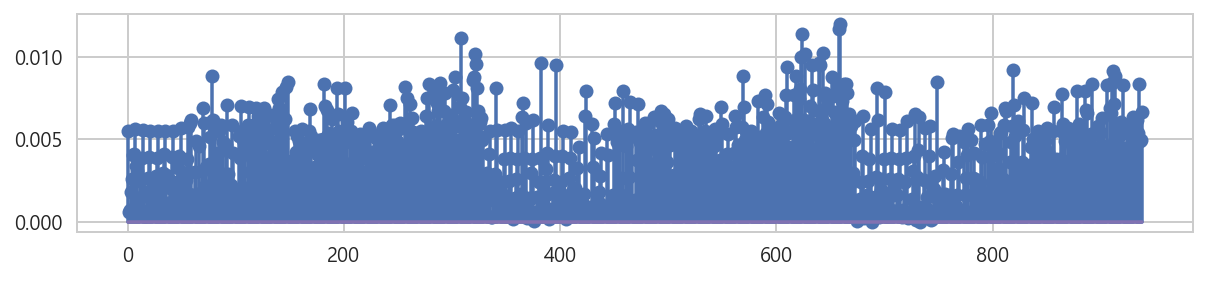

In [113]:
plt.figure(figsize=(10,2))
plt.stem(hat)

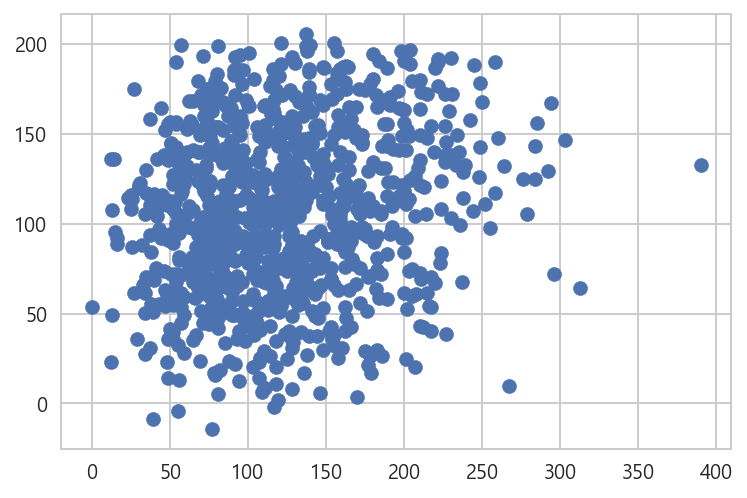

In [114]:
ax = plt.subplot()
plt.scatter(msdf.units, predictms)
plt.scatter(msdf[idx].units, predictms[idx], s=250, c="r", alpha=0.5)
plt.show()

In [128]:
#마지막 치팅 correlation 값 보기
item_df = master[(master["item_nbr"]==5)&(master["units"]<400)]
import pandas_profiling as pdp
pdp.ProfileReport(df)